<center><font size=6> Bank Churn Prediction </font></center>

## Problem Statement

In [ ]:
!jupyter nbconvert --to html INN_Learner_Notebook_Full_code_2.ipynb

[NbConvertApp] Converting notebook INN_Learner_Notebook_Full_code_2.ipynb to html
[NbConvertApp] Writing 5952542 bytes to INN_Learner_Notebook_Full_code_2.html


### Context

A bank provides service and worries about problem of 'Customer Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on improvement of service, keeping in mind these priorities.

### Objective

We need to  build a neural network based classifier that can determine whether a customer will leave the bank  or not in the next 6 months.

### Data Dictionary

* CustomerId: Unique ID which is assigned to each customer

* Surname: Last name of the customer

* CreditScore: It defines the credit history of the customer.
  
* Geography: A customer’s location
   
* Gender: It defines the Gender of the customer
   
* Age: Age of the customer
    
* Tenure: Number of years for which the customer has been with the bank

* NumOfProducts: refers to the number of products that a customer has purchased through the bank.

* Balance: Account balance

* HasCrCard: It is a categorical variable which decides whether the customer has credit card or not.

* EstimatedSalary: Estimated salary

* isActiveMember: Is is a categorical variable which decides whether the customer is active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions etc )

* Exited : whether or not the customer left the bank within six month. It can take two values
** 0=No ( Customer did not leave the bank )
** 1=Yes ( Customer left the bank )

## Importing necessary libraries

In [ ]:
# Installing the libraries with the specified version.
!pip install scikit-learn seaborn matplotlib numpy pandas imbalanced-learn -q --user --no-warn-script-location
#!pip install tensorflow==2.15.0 scikit-learn==1.2.2 seaborn==0.13.1 matplotlib==3.7.1 numpy==1.25.2 pandas==2.2.2 imbalanced-learn==0.10.1 -q --user --no-warn-script-location
#!pip install tensorflow==2.15.0 scikit-learn==1.2.2 seaborn==0.13.1 matplotlib==3.7.1 numpy==1.23.5 pandas==1.5.3 -q --user --no-warn-script-location

In [ ]:
!pip install tensorflow==2.17.0  -q --user --no-warn-script-location

In [ ]:
import pandas as pd  # Library for data manipulation and analysis.
import numpy as np   # Fundamental package for scientific computing.
import matplotlib.pyplot as plt  # Plotting library for creating visualizations.
import seaborn as sns #For advanced visualizations.

from sklearn.model_selection import train_test_split  # Function for splitting datasets for training and testing.
from sklearn.preprocessing import MinMaxScaler

import time  # Module for time-related operations.

import tensorflow as tf #An end-to-end open source machine learning platform
from tensorflow import keras  # High-level neural networks API for deep learning.
from keras import backend   # Abstraction layer for neural network backend engines.
from keras.models import Sequential  # Model for building NN sequentially.
from keras.layers import Dense, Dropout, Activation, BatchNormalization    # for creating fully connected neural network layers.



from imblearn.over_sampling import SMOTE    # importing SMOTE

from sklearn.metrics import confusion_matrix,roc_curve,classification_report,recall_score   # importing metrics

import random

      # Library to avoid the warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Set the seed using keras.utils.set_random_seed. This will set: 1) `numpy` seed 2) backend random seed 3) `python` random seed
keras.utils.set_random_seed(416)

# If using TensorFlow, this will make GPU ops as deterministic as possible, but it might affect the overall performance
tf.config.experimental.enable_op_determinism()

## Loading the dataset

In [ ]:
      # Mounting Driveto Colab
from google.colab import drive
drive.mount('/H', force_remount=True)

Mounted at /H


In [ ]:
      # Change working directory
%cd /H/My Drive/AIML Work/Project - Bank Churn Prediction

      # Importing the dataset
df0 = pd.read_csv('Churn.csv')       # reads orginal data form csv to df0

df1 = df0.copy()  # makes a copy of original data to modify


### Prelmiminary adding splitting variable

In [ ]:

      # TEMPORARILY Split into training and temporary sets (60% training, 40% temporary)
train_df, temp_df = train_test_split(df1, test_size=0.4, random_state=1, stratify=df1[['Exited','Geography']])
      # Then split the temporary set into validation and test sets (50% each of the temporary set)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=1, stratify=temp_df[['Exited','Geography']])


      # Define variable Dataset for future manipulations
train_df['Set'] = 'Train'
val_df['Set'] = 'Validation'
test_df['Set'] = 'Test'

      # Re-combine all 3 back into one but with new variable "Dataset"
data = pd.concat([train_df, val_df, test_df], ignore_index=True)
data = data.sample(frac=1, random_state=1).reset_index(drop=True)  # shuffle it just in case
print(data['Set'].value_counts(), end='\n')

is_train = data['Set'] == 'Train'
print(is_train.value_counts())


Set
Train         6000
Test          2000
Validation    2000
Name: count, dtype: int64
Set
True     6000
False    4000
Name: count, dtype: int64


## Data Overview

In [ ]:
data.shape  # checking shape of data

(10000, 15)

In [ ]:
data.info()  # checking data types of each column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
 14  Set              10000 non-null  object 
dtypes: float64(2), int64(9), object(4)
memory usage: 1.1+ MB


In [ ]:
data.head(20)  # checking first 20 records;

RowNumber  CustomerId      Surname  CreditScore Geography  Gender  Age  \
0        9048    15738662      Daluchi          652   Germany    Male   41   
1        5209    15664737          Lei          779     Spain  Female   38   
2        6323    15684294    Chidumaga          735    France    Male   50   
3        4990    15602851       Ozioma          629    France    Male   40   
4        2981    15709476       Kenyon          850     Spain  Female   41   
5        6621    15751297       Wilson          732    France    Male   36   
6        9817    15649508         Chin          643     Spain    Male   48   
7         459    15707362          Yin          514   Germany    Male   43   
8        4070    15656613     McGregor          646    France  Female   34   
9        4488    15614365     Lombardi          696   Germany    Male   31   
10       8921    15697546     McIntyre          570    France  Female   36   
11       7419    15647191     Lucchesi          677    France    Male   36   
12       5863    15656484        Woods          682    France    Male   40   
13       7932    15751227  Ebelegbulam          807    France    Male   47   
14       7353    15809800     Korovina          726    France  Female   38   
15       2053    15644765       Ashton          689   Germany    Male   26   
16       9617    15664539        Bruce          683     Spain    Male   35   
17       7265    15662189       Durant          434     Spain    Male   33   
18       7538    15773776           Ho          655    France  Female   38   
19       2816    15721307    Pickering          694   Germany    Male   37   

    Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0        9  159434.03              1          1               0   
1        7       0.00              2          1               1   
2        2       0.00              2          0               1   
3        9       0.00              1          1               0   
4        3   99945.93              2          1               0   
5        5       0.00              2          1               0   
6        8       0.00              2          1               0   
7        1   95556.31              1          0               1   
8        3  131283.11              1          0               0   
9        3  150604.52              1          0               0   
10       3       0.00              2          1               0   
11       4       0.00              2          1               0   
12       4       0.00              2          1               1   
13       1   95120.59              1          0               0   
14       4       0.00              2          0               0   
15       4  120727.97              1          0               1   
16       9   61172.04              1          0               0   
17       3       0.00              1          1               1   
18       6       0.00              1          1               1   
19       1   95668.82              2          1               0   

    EstimatedSalary  Exited         Set  
0         178373.93       0        Test  
1         138542.87       0       Train  
2         147075.69       0       Train  
3            106.67       0       Train  
4          71179.31       0       Train  
5         161428.25       0        Test  
6         174729.30       0       Train  
7         199273.98       1       Train  
8         130500.65       0       Train  
9           5566.60       0        Test  
10         92118.75       0        Test  
11          7824.31       0       Train  
12        140745.91       0  Validation  
13        127875.10       0       Train  
14          6787.48       0  Validation  
15        149073.88       0  Validation  
16         82951.12       0  Validation  
17          2739.71       0  Validation  
18        188639.28       0  Validation  
19        100335.55       0  Validation

In [ ]:
data.tail(20)  # checking last 20 records

RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
9980       7041    15655658   Bulgakov          678    France  Female   48   
9981       5312    15584338       Winn          714    France  Female   40   
9982       8256    15708139      Brown          575    France  Female   40   
9983       9079    15705448    Gilbert          647   Germany    Male   52   
9984       4105    15676571  Bezrukova          850    France    Male   55   
9985       5778    15642248         Ko          608     Spain    Male   66   
9986       8884    15707696         Lu          471     Spain  Female   28   
9987       8712    15673995         Tu          516     Spain  Female   65   
9988       7358    15570947      Bruny          615     Spain  Female   29   
9989       6083    15636820     Loggia          725   Germany    Male   40   
9990       9223    15620750     Sugden          559    France    Male   28   
9991       1142    15716134      Russo          617    France    Male   40   
9992       1318    15720702       Shih          789    France    Male   37   
9993       2300    15763171         Hu          650   Germany  Female   25   
9994       3985    15695225        Sun          834     Spain    Male   38   
9995       6457    15755978      Tseng          606    France    Male   31   
9996       6460    15632125      Blake          606   Germany    Male   45   
9997       3145    15638003   Komarova          648     Spain    Male   55   
9998       8106    15635116     Burgos          659     Spain    Male   60   
9999       6197    15576304     Bailey          698    France    Male   29   

      Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
9980       2       0.00              2          1               1   
9981       0       0.00              2          1               0   
9982       1  139532.34              1          1               0   
9983       7  130013.12              1          1               1   
9984       6       0.00              1          1               0   
9985       8  123935.35              1          1               1   
9986       5       0.00              2          1               1   
9987       9  102541.10              1          1               0   
9988       7  143330.56              2          1               1   
9989       8  104149.66              1          1               0   
9990       3  141099.43              1          1               1   
9991       5  190008.32              2          1               1   
9992       3       0.00              1          1               0   
9993       2  114330.95              1          1               1   
9994       8       0.00              2          1               1   
9995      10       0.00              2          1               0   
9996       5   63832.43              1          1               1   
9997       1   81370.07              1          0               1   
9998       2       0.00              1          1               0   
9999       5   95167.55              1          1               1   

      EstimatedSalary  Exited         Set  
9980         32301.88       0  Validation  
9981         62762.12       0        Test  
9982        181294.39       0       Train  
9983        190806.36       1       Train  
9984           944.41       1        Test  
9985         65758.19       0       Train  
9986         22356.97       0       Train  
9987        181490.42       0       Train  
9988        126396.01       0       Train  
9989         62027.90       0        Test  
9990         15607.27       0       Train  
9991        107047.92       0  Validation  
9992        121883.87       1       Train  
9993         25325.07       0       Train  
9994         66485.26       0       Train  
9995        195209.40       0       Train  
9996         93707.80       0  Validation  
9997        181534.04       0       Train  
9998        177480.45       1       Train  
9999        152723.23       0       T

### NOTES:
- There are no explicit missing values
- There are 13 variables + 1 splitting data into 3 parts
- There are up to 10,000 data records
- There might more missing values in any variable not explicitly coded as missing yet: **Need to Check**
- There is a mix of variable stypes reuiring deeper look into if they are coded optimally: **Need to Check**

### Check Data for dups and 2+ records per customer ID

In [ ]:
data['CustomerId'].nunique()  # Counts number of unique customer IDs

10000

### NOTES:
- All Customer IDs are unique records  (count of uniques = total data records)

In [ ]:
data.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
Set                    3
dtype: int64

In [ ]:
data.duplicated().sum()  # checking for duplicate records

0

### NOTES:
- there are no pudlicated records
- all customer IDs are unique
- no repeats in surname - potentially meanignless predictor
- note that almost all salaries are uniques - means they are all estimates from some model and not real collected values



# Check the data types of the columns for the dataset

In [ ]:
# checking for unusual values in data
for column in data.columns[1:]:
    print('\n' + "-" * 50)
    print(data[column].value_counts())


--------------------------------------------------
CustomerId
15738662    1
15792660    1
15639217    1
15588019    1
15614230    1
           ..
15692926    1
15629885    1
15729435    1
15806249    1
15576304    1
Name: count, Length: 10000, dtype: int64

--------------------------------------------------
Surname
Smith       32
Martin      29
Scott       29
Walker      28
Brown       26
            ..
Wickham      1
Pardey       1
Jensen       1
Northern     1
Burgos       1
Name: count, Length: 2932, dtype: int64

--------------------------------------------------
CreditScore
850    233
678     63
655     54
667     53
705     53
      ... 
395      1
442      1
373      1
441      1
359      1
Name: count, Length: 460, dtype: int64

--------------------------------------------------
Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

--------------------------------------------------
Gender
Male      5457
Female    4543
Name: count, dtype: int64

-

### NOTES:
- 3 countries means 3 distinct markets potentially with different dynamics, different drivers of churn
- Tenure has half-count at min and max tenure (0 and 10 years respectively). Possibly because of incomplete year in data collected at current (0) and first year (10 years ago)


### SUGGESTION:
- Include Geography into inital stratification above
- Age, Balance and Salary might need alternative bucketing to compete with their own linear form of presentation


In [ ]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)    #RowNumber , CustomerId and Surname are unique hence dropping it
data.head()

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          652   Germany    Male   41       9  159434.03              1   
1          779     Spain  Female   38       7       0.00              2   
2          735    France    Male   50       2       0.00              2   
3          629    France    Male   40       9       0.00              1   
4          850     Spain  Female   41       3   99945.93              2   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited    Set  
0          1               0        178373.93       0   Test  
1          1               1        138542.87       0  Train  
2          0               1        147075.69       0  Train  
3          1               0           106.67       0  Train  
4          1               0         71179.31       0  Train

## Exploratory Data Analysis

### Univariate Analysis

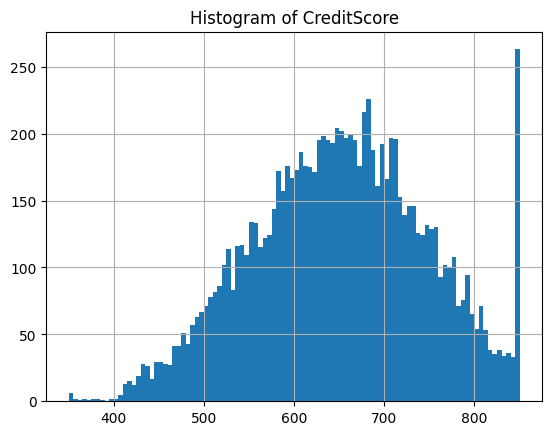

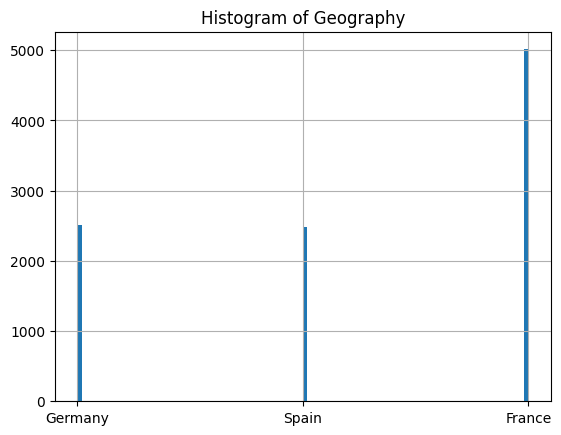

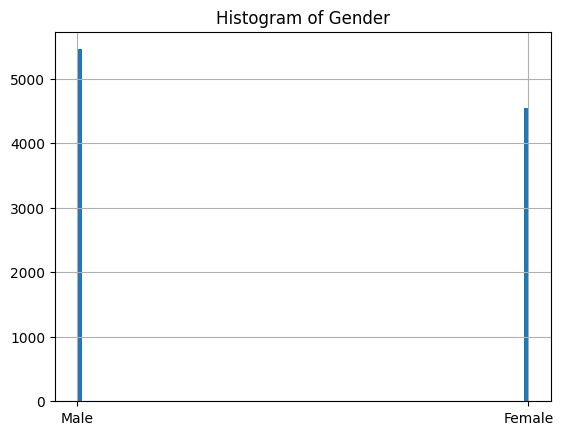

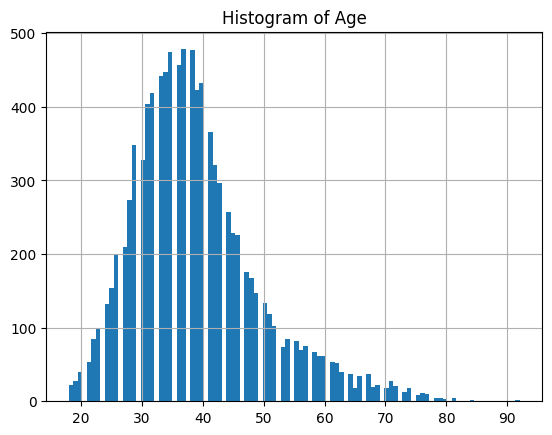

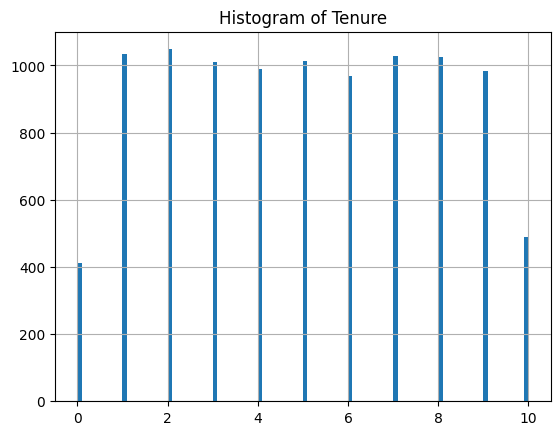

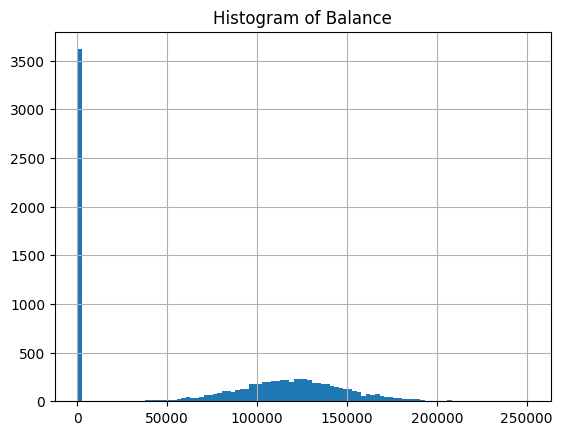

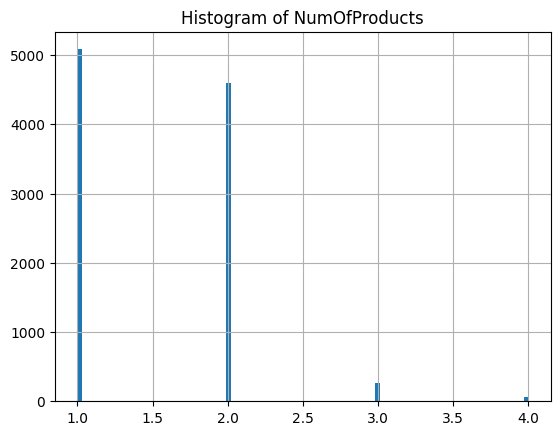

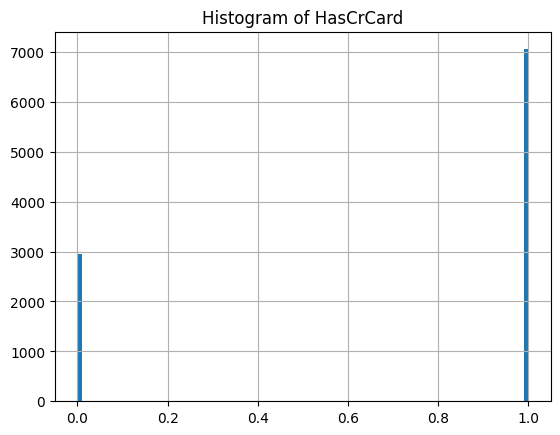

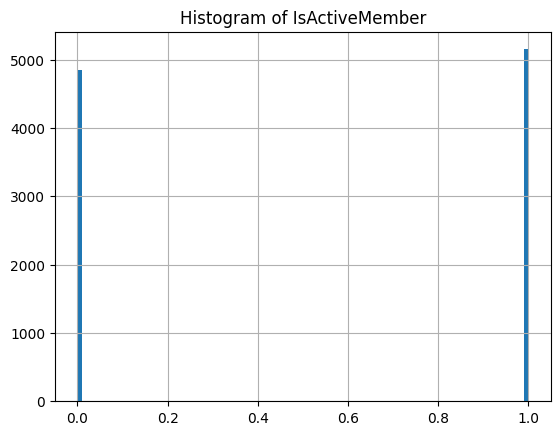

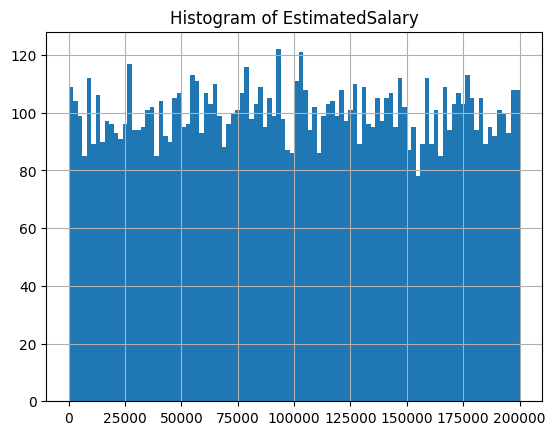

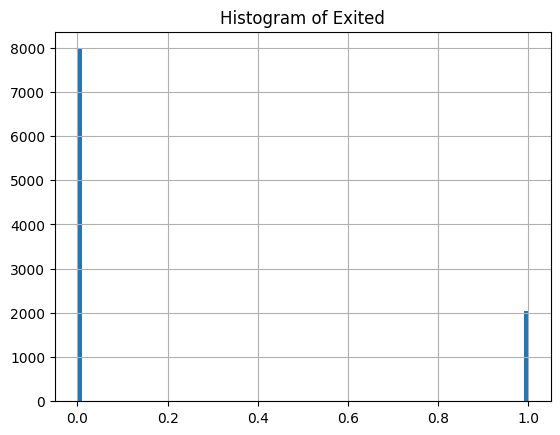

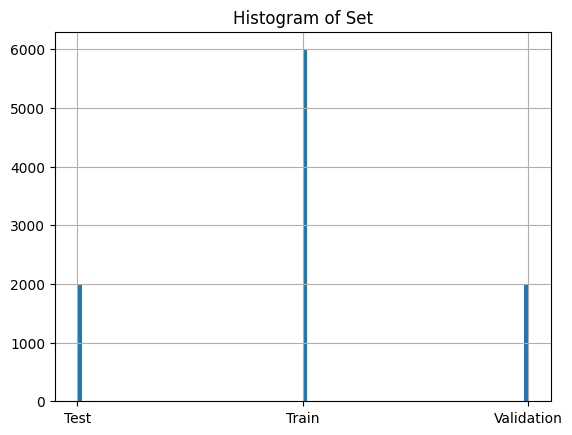

In [ ]:
for column in data.columns[:]:
    plt.title(f'Histogram of {column}')
    data[column].hist(bins=100)
    plt.show()

### NOTES:
- the data does not appear the be real-world data but looks synthetically generated at least parts:
- Salary range seems to be UNIFORM distribution in a wide range of salaries - unlikely a real life distribution


## Check if Balance amount and Salary Estimate should be taken to country level

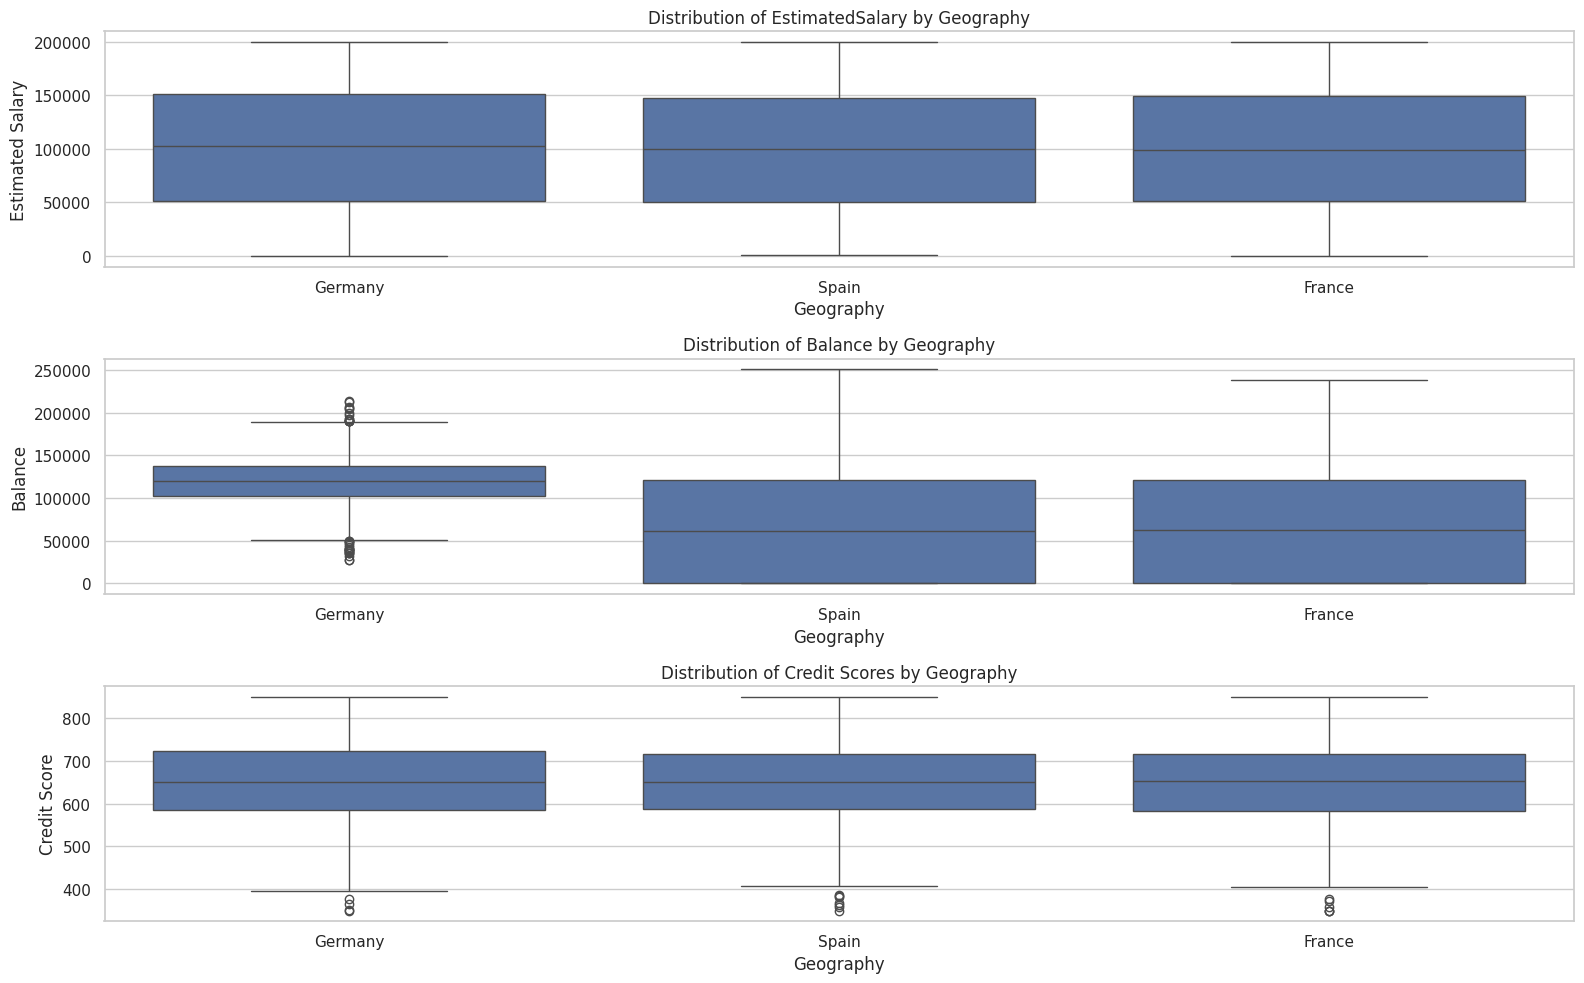

In [ ]:
      # Set up the figure size and style for Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(16, 10))

    # Plot distribution of EstimatedSalary by Geography
plt.subplot(3, 1, 1)
sns.boxplot(data=data, x='Geography', y='EstimatedSalary')
plt.title('Distribution of EstimatedSalary by Geography')
plt.xlabel('Geography')
plt.ylabel('Estimated Salary')

    # Plot distribution of Balance by Geography
plt.subplot(3, 1, 2)
sns.boxplot(data=data, x='Geography', y='Balance')
plt.title('Distribution of Balance by Geography')
plt.xlabel('Geography')
plt.ylabel('Balance')

    # Plot distribution of CreditScore by Geography
plt.subplot(3, 1, 3)
sns.boxplot(data=data, x='Geography', y='CreditScore')
plt.title('Distribution of Credit Scores by Geography')
plt.xlabel('Geography')
plt.ylabel('Credit Score')

# Show plots
plt.tight_layout()
plt.show()

### NOTES:
- Further evidence that Estimated Salary data is synthetically generated garbage  - there is no difference in distribution of salaries between all 3 countries incuding richest Germany and poorest Spain among these contries
- Eventhough the difference between countries is seen in the distribution of balance amounts
- Credit SCores are not very different between countries


### SUGGESTIONS:
- given evidence of significant market differences, lets center Balance and Salary within each country separately (even though we don't trust Salary data but we will do our diligence and let the model to kill this predictor via feature selection OR via input weights downgrade for this or related predictor
- we will not center credit scores

### Centering Salary and Balance Amount within each country withih train / validate and test sets separately in order to prevent data leakage

In [ ]:
# Create centered versions based on Geography within each of the Train, Validation, and Test sets separately

data['Balance_cnt'] = data.groupby(['Set', 'Geography'])['Balance'].transform(lambda x: x - x.mean())
data['EstimatedSalary_cnt'] = data.groupby(['Set', 'Geography'])['EstimatedSalary'].transform(lambda x: x - x.mean())

# Create bucketed versions of the centered features (using quantiles for simplicity) within each split
data['Age_net'] = data.groupby(['Set', 'Geography'])['Age'].transform(lambda x: pd.qcut(x, q=7, labels=False, duplicates='drop'))
data['Balance_cnt_net'] = data.groupby(['Set', 'Geography'])['Balance_cnt'].transform(lambda x: pd.qcut(x, q=5, labels=False, duplicates='drop'))
data['EstimatedSalary_cnt_net'] = data.groupby(['Set', 'Geography'])['EstimatedSalary_cnt'].transform(lambda x: pd.qcut(x, q=5, labels=False, duplicates='drop'))

# Display the first few rows of the dataset to verify new features
data[['Set', 'Geography', 'Age', 'Age_net',
      'Balance', 'Balance_cnt', 'Balance_cnt_net',
      'EstimatedSalary', 'EstimatedSalary_cnt', 'EstimatedSalary_cnt_net']].head()

Set Geography  Age  Age_net    Balance   Balance_cnt  Balance_cnt_net  \
0   Test   Germany   41        4  159434.03  38738.996574                4   
1  Train     Spain   38        3       0.00 -62568.202981                0   
2  Train    France   50        6       0.00 -62721.866178                0   
3  Train    France   40        4       0.00 -62721.866178                0   
4  Train     Spain   41        4   99945.93  37377.727019                1   

   EstimatedSalary  EstimatedSalary_cnt  EstimatedSalary_cnt_net  
0        178373.93         78394.016116                        4  
1        138542.87         39962.109845                        3  
2        147075.69         46537.965407                        3  
3           106.67       -100431.054593                        0  
4         71179.31        -27401.450155                        1

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CreditScore              10000 non-null  int64  
 1   Geography                10000 non-null  object 
 2   Gender                   10000 non-null  object 
 3   Age                      10000 non-null  int64  
 4   Tenure                   10000 non-null  int64  
 5   Balance                  10000 non-null  float64
 6   NumOfProducts            10000 non-null  int64  
 7   HasCrCard                10000 non-null  int64  
 8   IsActiveMember           10000 non-null  int64  
 9   EstimatedSalary          10000 non-null  float64
 10  Exited                   10000 non-null  int64  
 11  Set                      10000 non-null  object 
 12  Balance_cnt              10000 non-null  float64
 13  EstimatedSalary_cnt      10000 non-null  float64
 14  Age_net                

### Lets Convert Object Predictors to Integers

In [ ]:

# Convert categorical variables Gender and Geography into dummy variables
data = pd.get_dummies(data, columns=['Gender', 'Geography'], drop_first=True)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CreditScore              10000 non-null  int64  
 1   Age                      10000 non-null  int64  
 2   Tenure                   10000 non-null  int64  
 3   Balance                  10000 non-null  float64
 4   NumOfProducts            10000 non-null  int64  
 5   HasCrCard                10000 non-null  int64  
 6   IsActiveMember           10000 non-null  int64  
 7   EstimatedSalary          10000 non-null  float64
 8   Exited                   10000 non-null  int64  
 9   Set                      10000 non-null  object 
 10  Balance_cnt              10000 non-null  float64
 11  EstimatedSalary_cnt      10000 non-null  float64
 12  Age_net                  10000 non-null  int64  
 13  Balance_cnt_net          10000 non-null  int64  
 14  EstimatedSalary_cnt_net

### Bivariate Analysis

### Review Impact of Bivariate Interactions between preditors on Churn

Selected Columns for Pairplot:
['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Balance_cnt', 'EstimatedSalary_cnt', 'Age_net', 'Balance_cnt_net', 'EstimatedSalary_cnt_net']


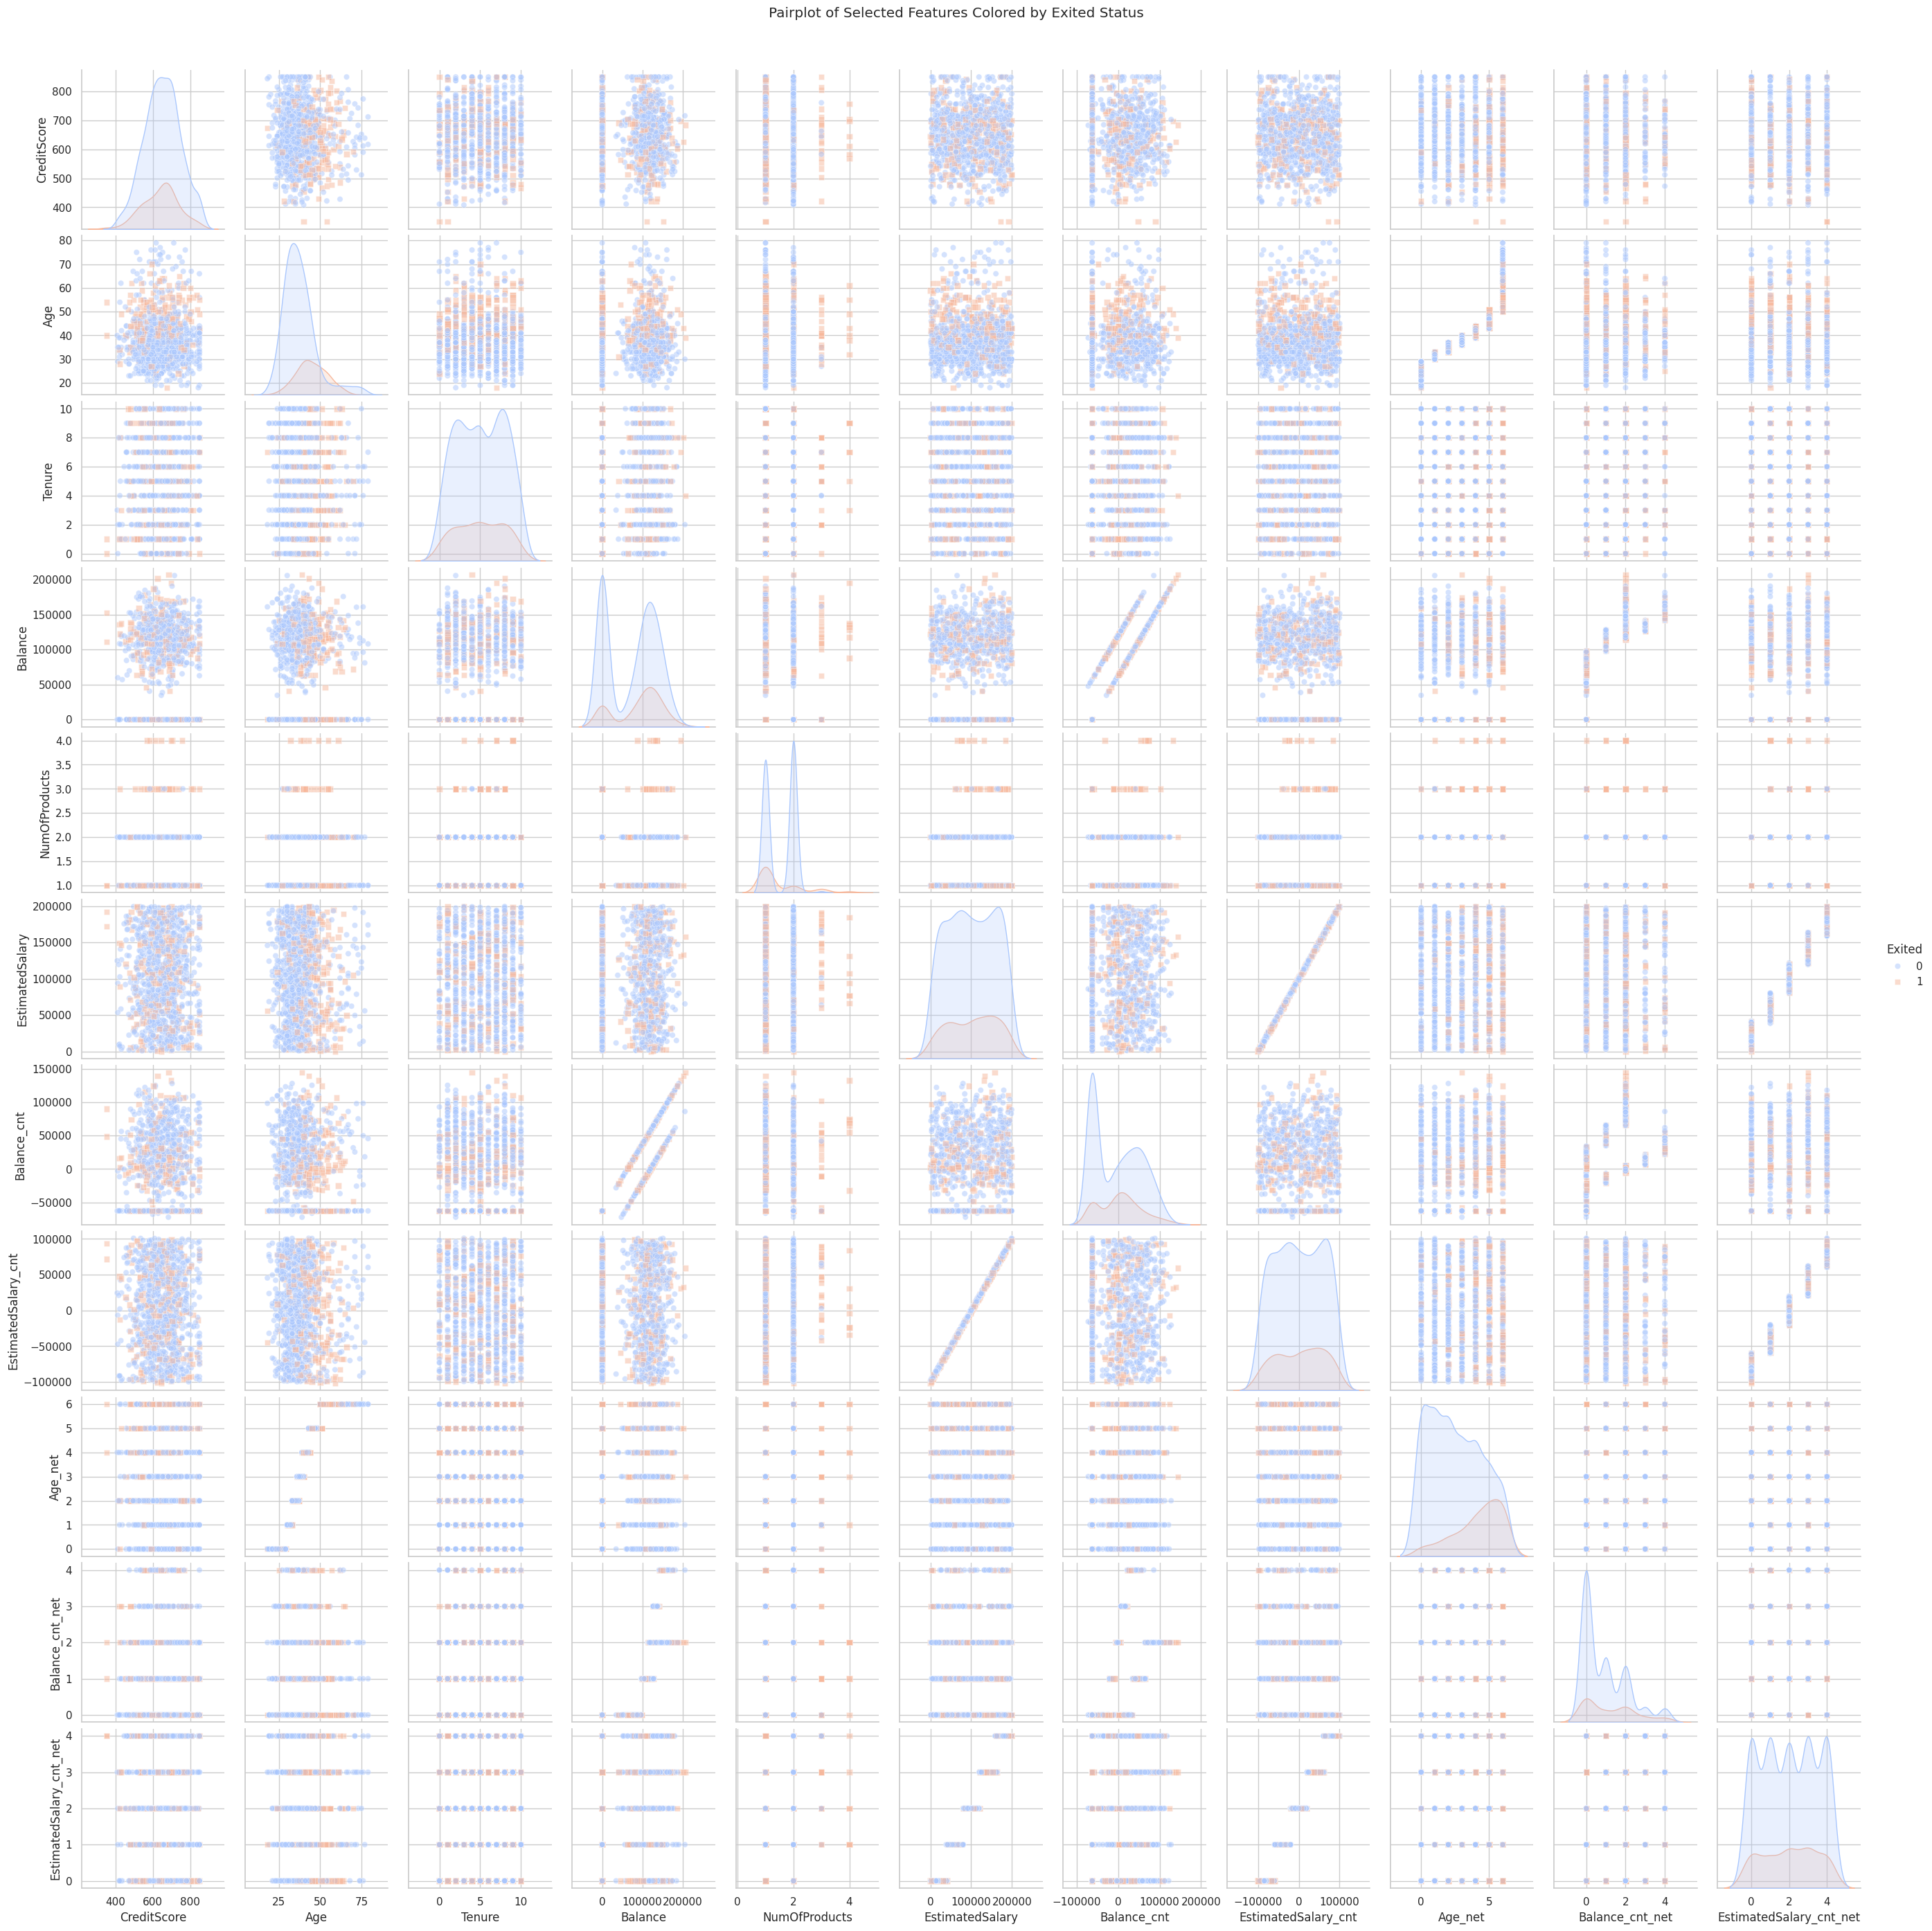

In [ ]:
      # lets review relations to "Exited" on small random portion of train data
sampled_data = data[data['Set'] == 'Train'].sample(n=1000, random_state=1)

numeric_columns = sampled_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
  # Exclude non-relevant columns
exclude_cols = [
    'Exited', 'Set', 'HasCrCard', 'IsActiveMember'
]

pairplot_columns = [col for col in numeric_columns if col not in exclude_cols]

sampled_data['Exited'] = sampled_data['Exited'].astype('category')

print("Selected Columns for Pairplot:")
print(pairplot_columns)



sns.pairplot(
    sampled_data,
    vars=pairplot_columns,
    hue='Exited',
    palette='coolwarm',
    diag_kind='kde',
    markers=["o", "s"],
    plot_kws={'alpha': 0.5}
)

plt.suptitle('Pairplot of Selected Features Colored by Exited Status', y=1.02)
plt.show()

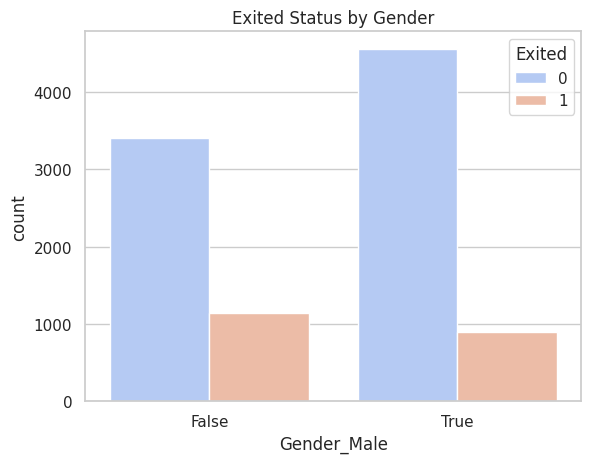

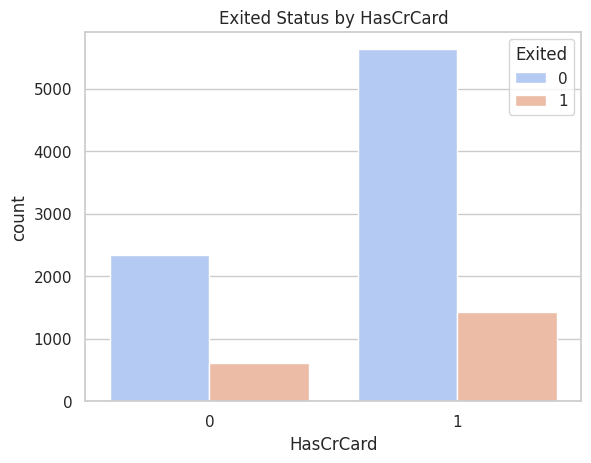

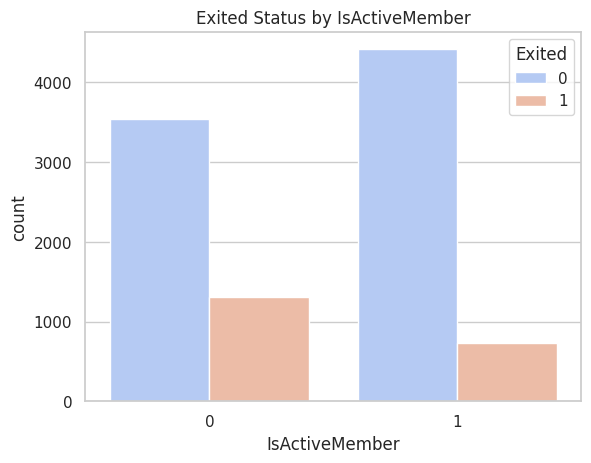

In [ ]:
# Plot for Gender
sns.countplot(data=data, x='Gender_Male', hue='Exited', palette='coolwarm')
plt.title('Exited Status by Gender')
plt.show()

# Plot for HasCrCard
sns.countplot(data=data, x='HasCrCard', hue='Exited', palette='coolwarm')
plt.title('Exited Status by HasCrCard')
plt.show()

# Plot for IsActiveMember
sns.countplot(data=data, x='IsActiveMember', hue='Exited', palette='coolwarm')
plt.title('Exited Status by IsActiveMember')
plt.show()

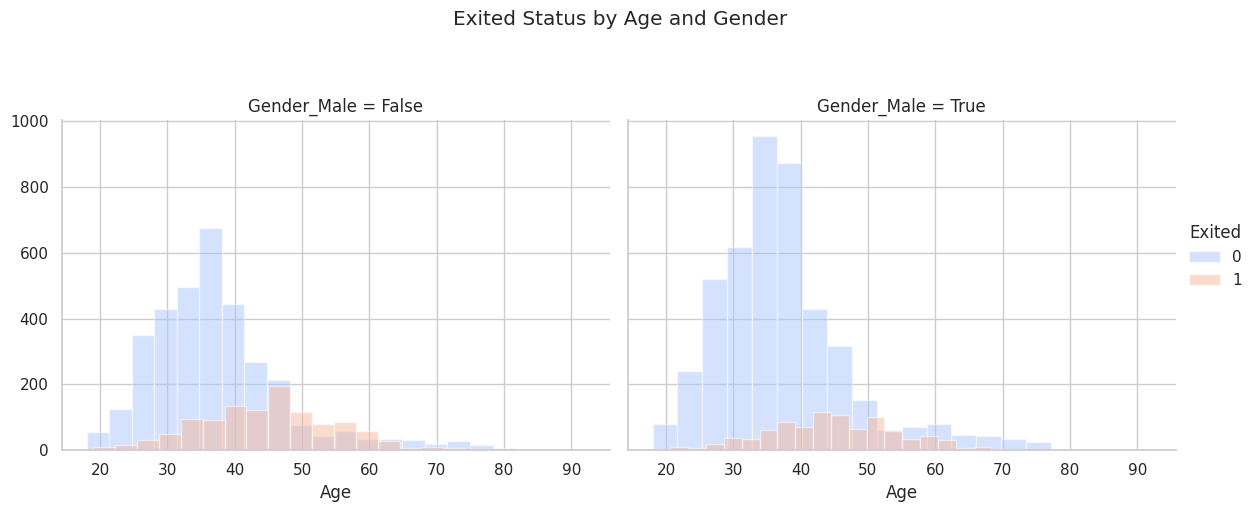

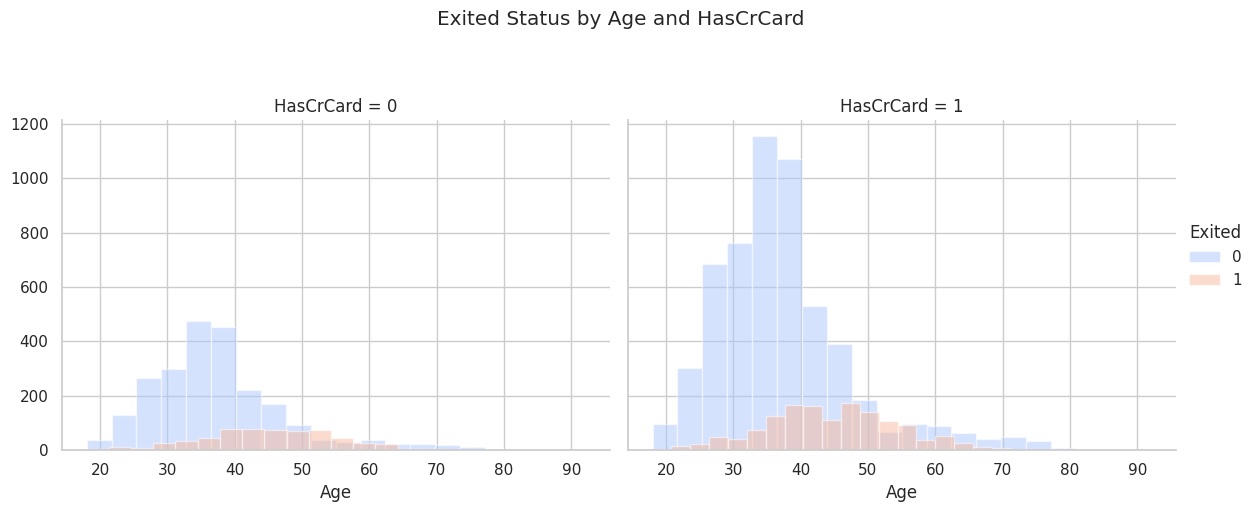

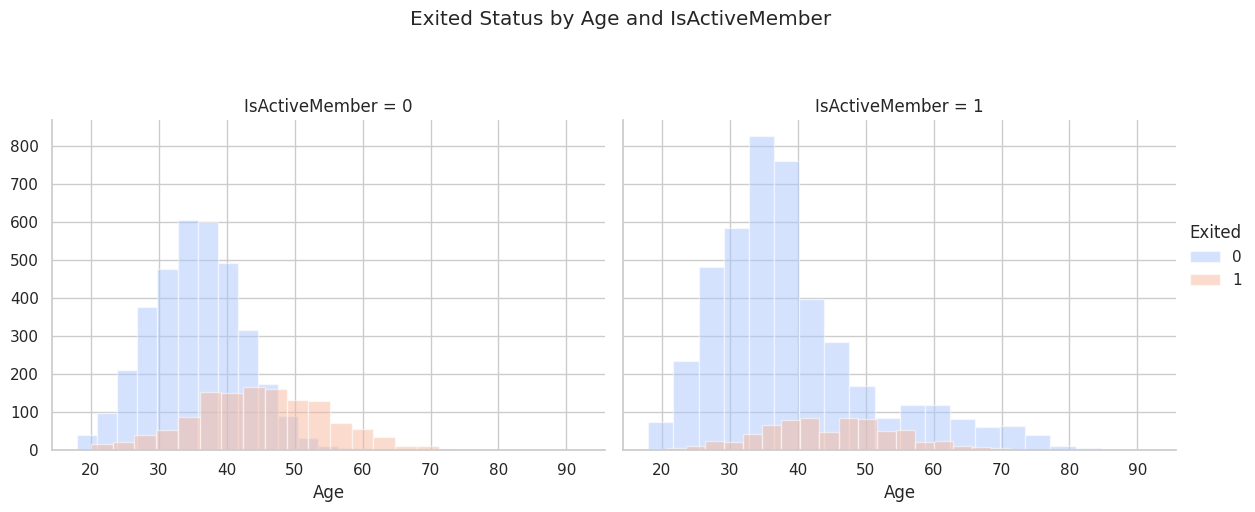

In [ ]:

# FacetGrid: Interaction between Gender and Age against Exited
g = sns.FacetGrid(data, col='Gender_Male', hue='Exited', palette='coolwarm', height=5, aspect=1.2)
g.map(plt.hist, 'Age', alpha=0.5, bins=20)
g.add_legend()
plt.subplots_adjust(top=0.8)
plt.suptitle('Exited Status by Age and Gender', y=1.02)
plt.show()


# FacetGrid: Interaction between HasCrCard and Age against Exited
g = sns.FacetGrid(data, col='HasCrCard', hue='Exited', palette='coolwarm', height=5, aspect=1.2)
g.map(plt.hist, 'Age', alpha=0.5, bins=20)
g.add_legend()
plt.subplots_adjust(top=0.8)
plt.suptitle('Exited Status by Age and HasCrCard', y=1.02)
plt.show()

# Repeat for IsActiveMember
g = sns.FacetGrid(data, col='IsActiveMember', hue='Exited', palette='coolwarm', height=5, aspect=1.2)
g.map(plt.hist, 'Age', alpha=0.5, bins=20)
g.add_legend()
plt.subplots_adjust(top=0.8)
plt.suptitle('Exited Status by Age and IsActiveMember', y=1.02)
plt.show()



### NOTES:
- IsActiveMember and Gender has some effect on Exited
- But effect of HasCrCard on Exited very small as the main effect, still need some investigation re possibility of any iteraction with other predictor


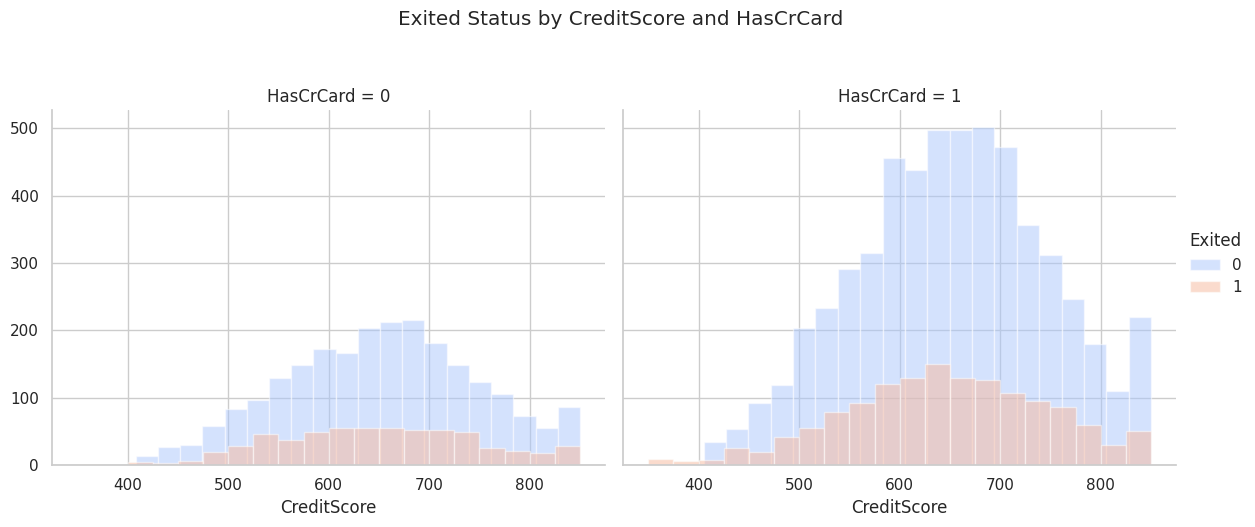

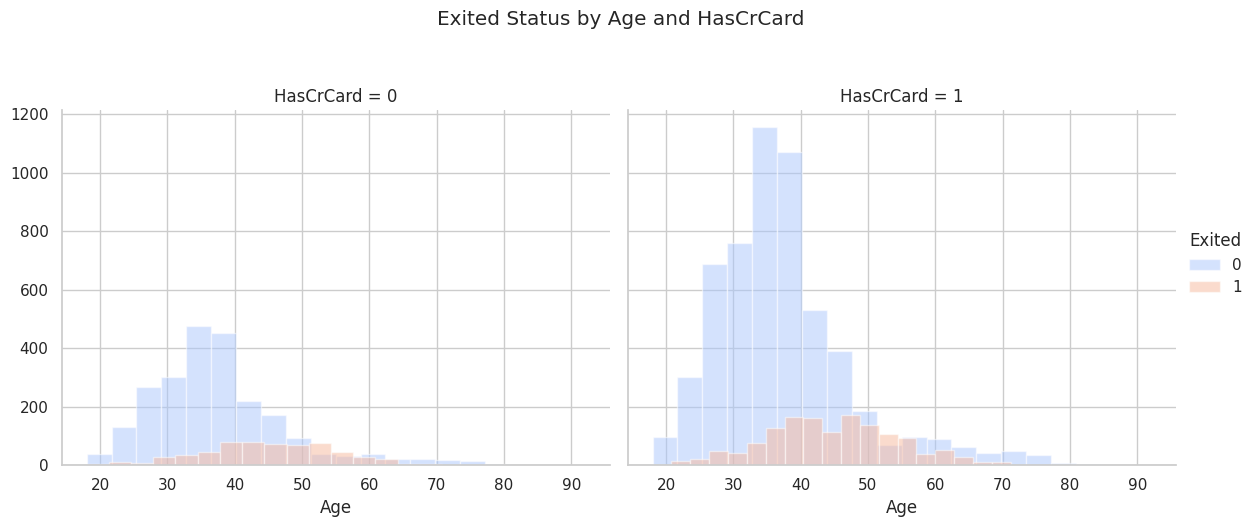

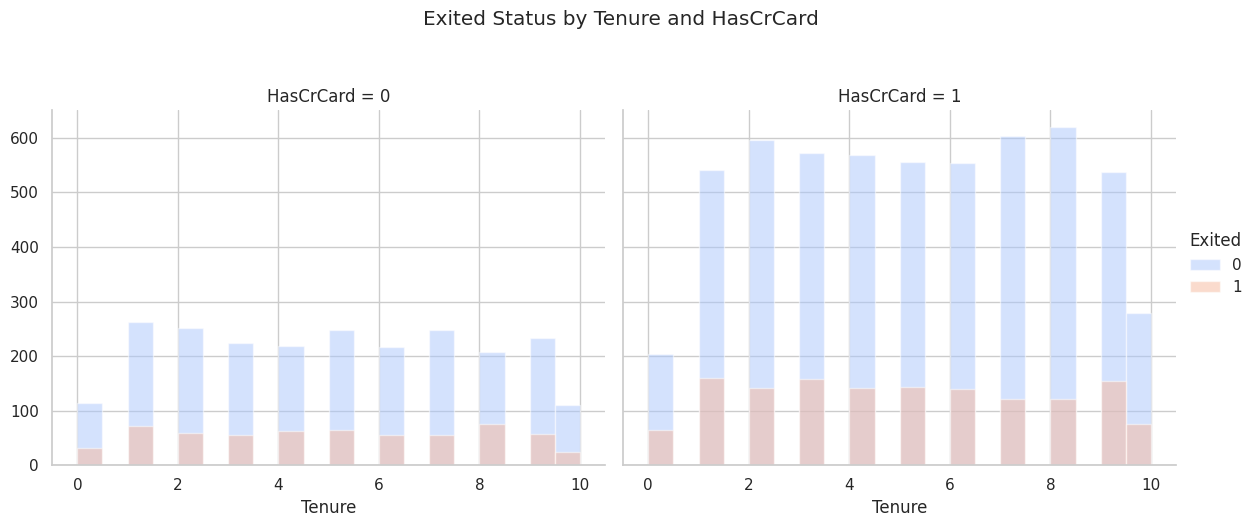

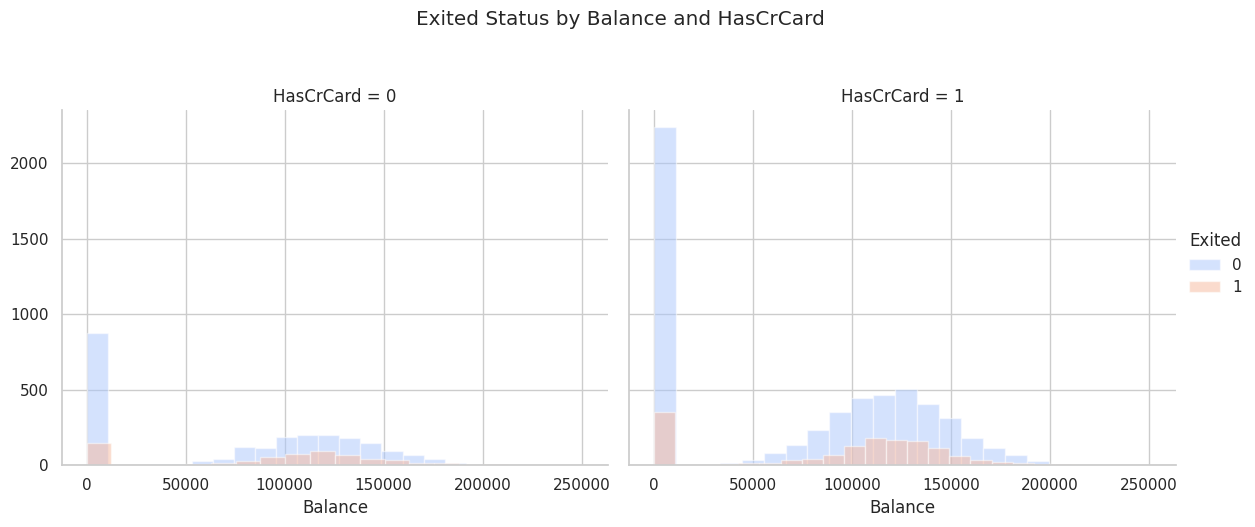

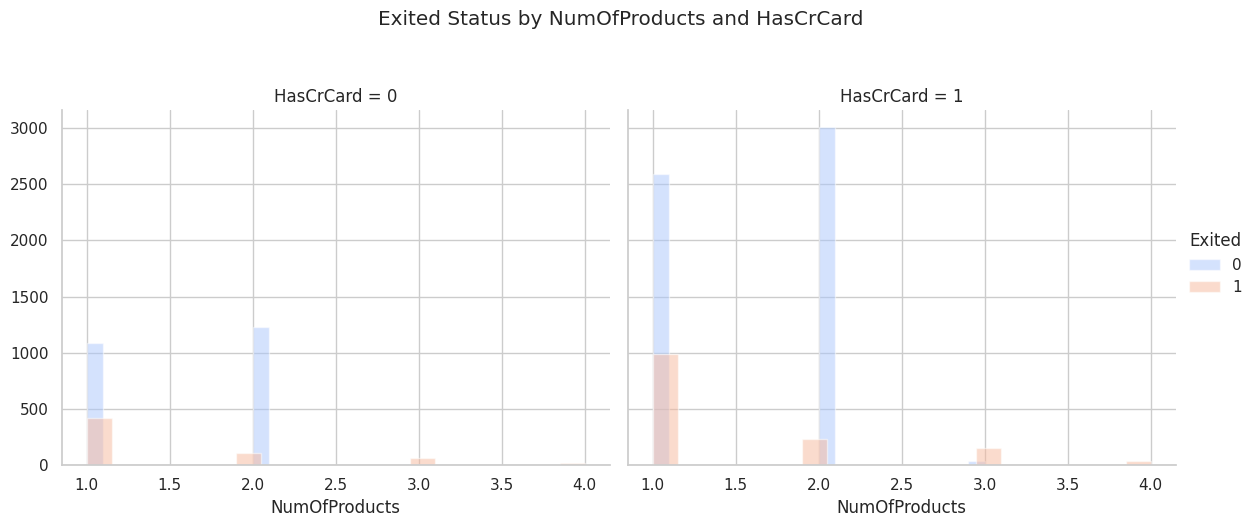

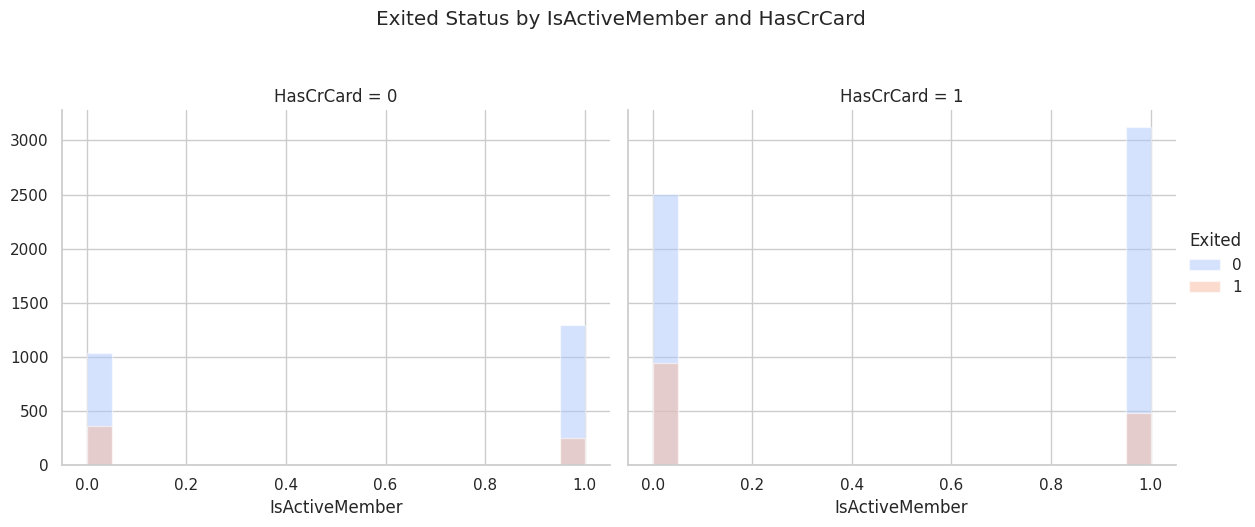

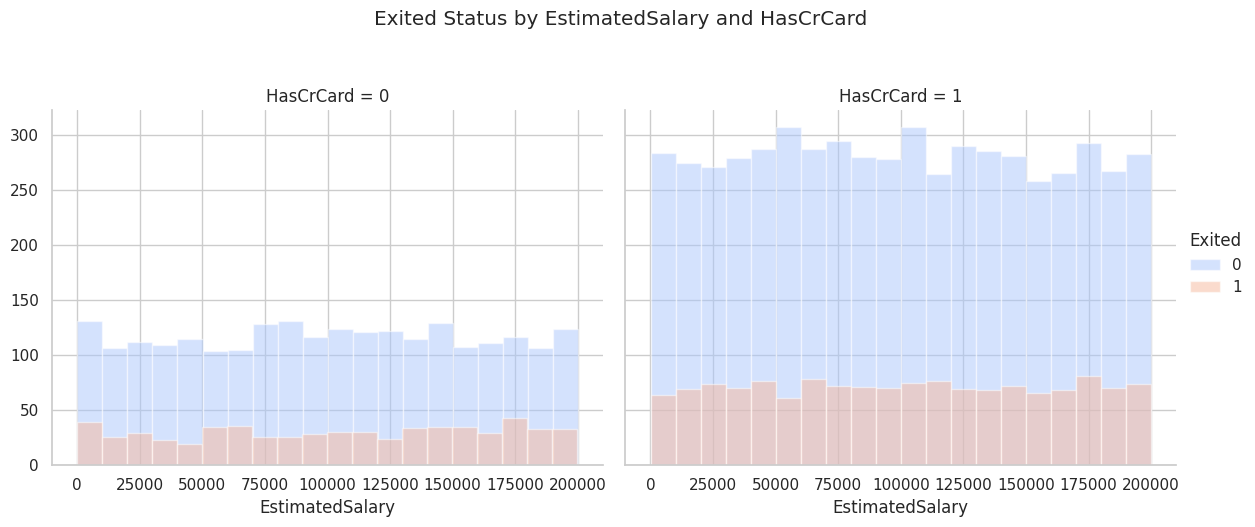

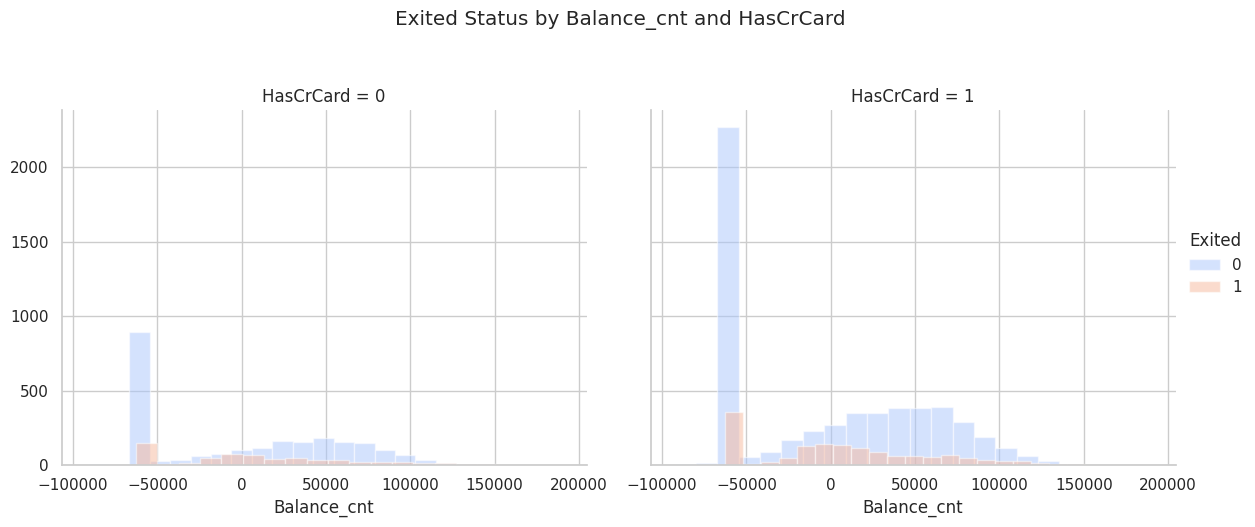

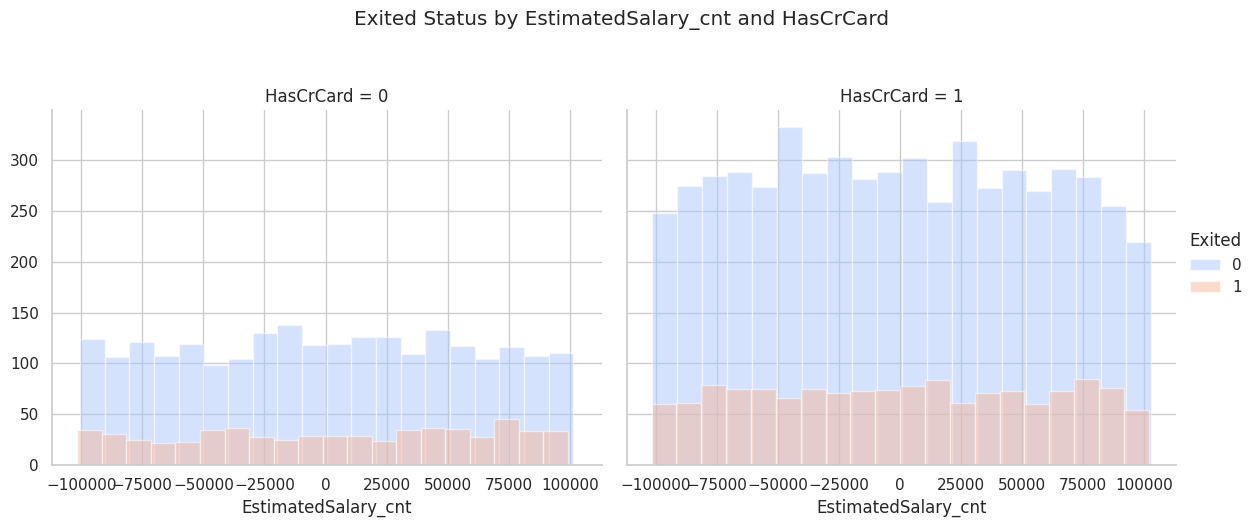

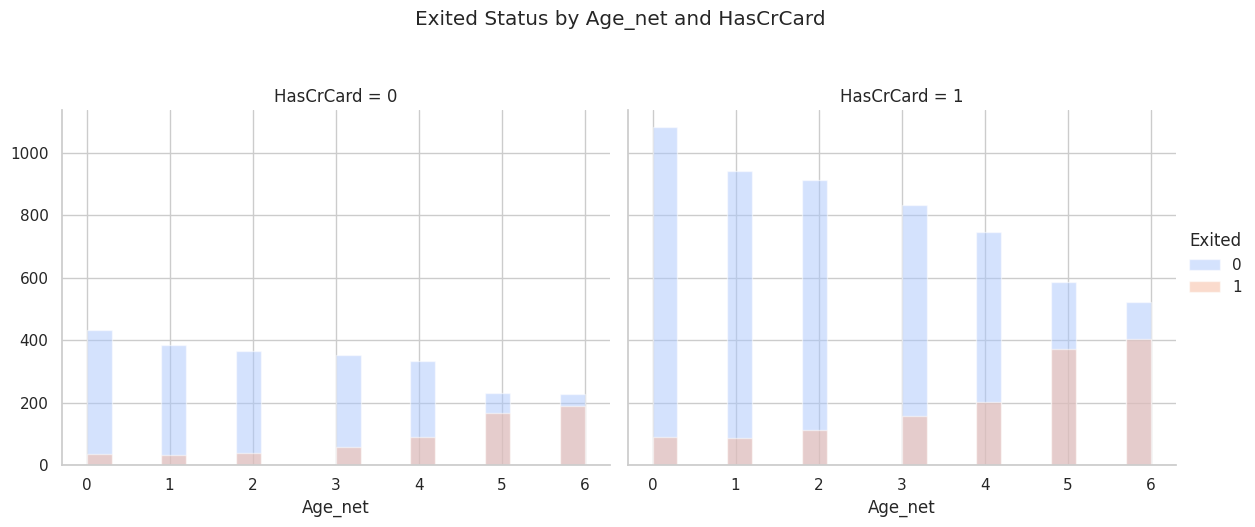

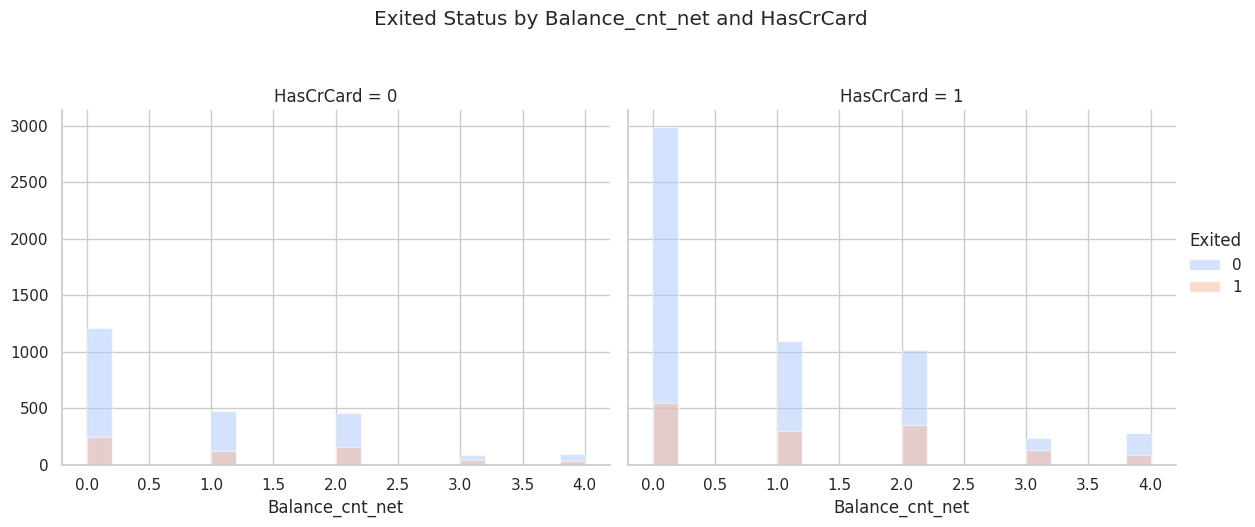

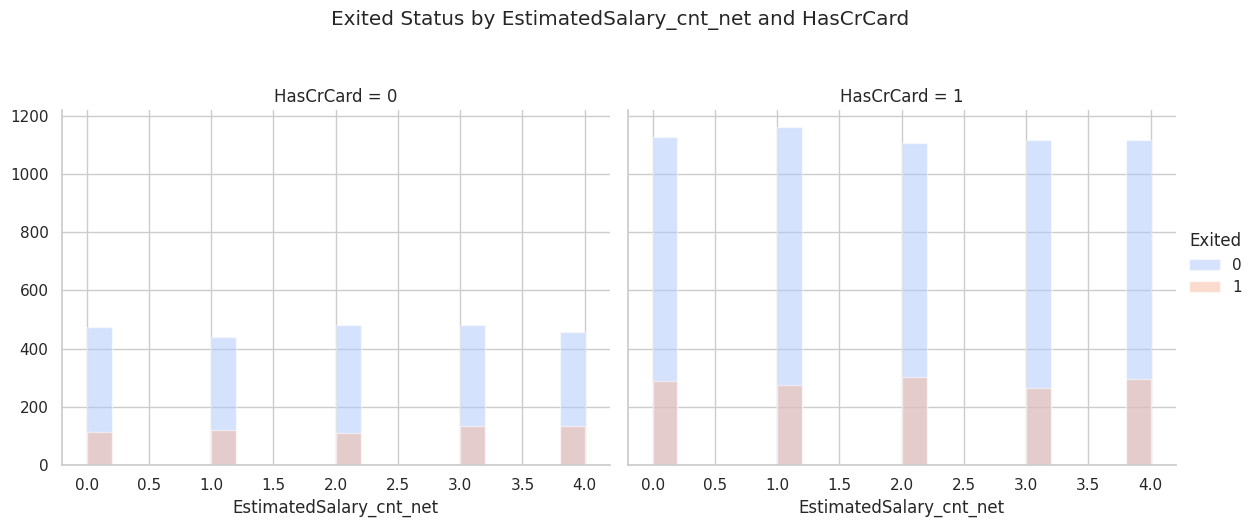

In [ ]:
def cycle_facetgrid_interactions(data, binary_var, target_var='Exited'):
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns.tolist()

          # Exclude columns that are not predictors
    exclude_cols = ['Set', binary_var, target_var]
    numeric_columns = [col for col in numeric_columns if col not in exclude_cols]

          # Cycle through numeric columns and create FacetGrid visualizations
    for column in numeric_columns:
        g = sns.FacetGrid(data, col=binary_var, hue=target_var, palette='coolwarm', height=5, aspect=1.2)
        g.map(plt.hist, column, alpha=0.5, bins=20)
        g.add_legend()
        plt.subplots_adjust(top=0.85)
        plt.suptitle(f'Exited Status by {column} and {binary_var}', y=1.05)
        plt.show()

      # Running this function for HasCrCard
cycle_facetgrid_interactions(data, binary_var='HasCrCard', target_var='Exited')

### NOTE:
- HasCrCard did not show any potential for any impactful interaction effects neither:  Exclude form analysis

### Explore additional possible interaction effects of Tenure with remaining binaries on Exited

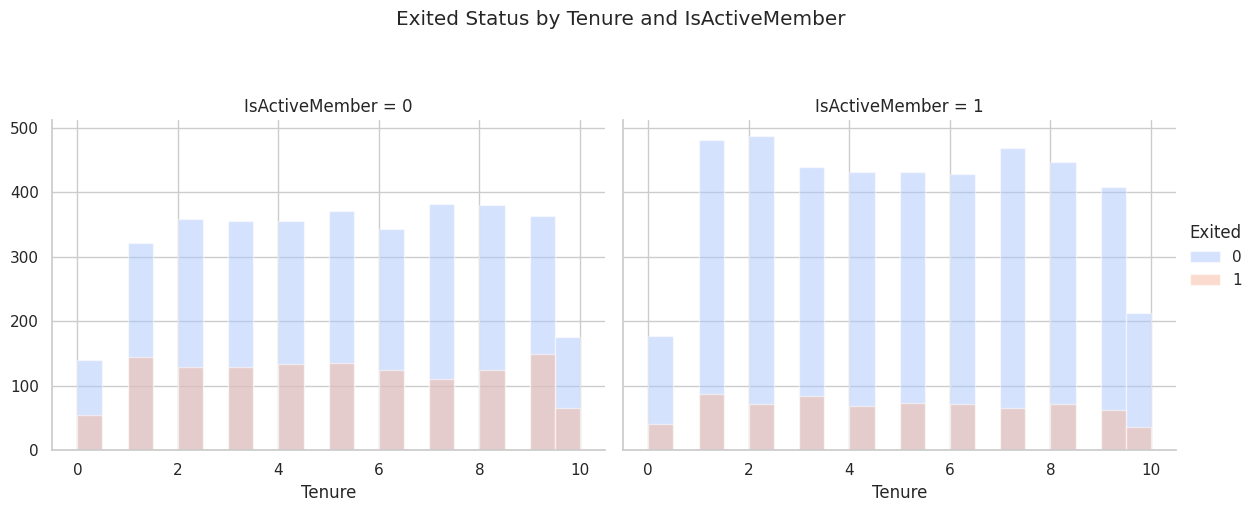

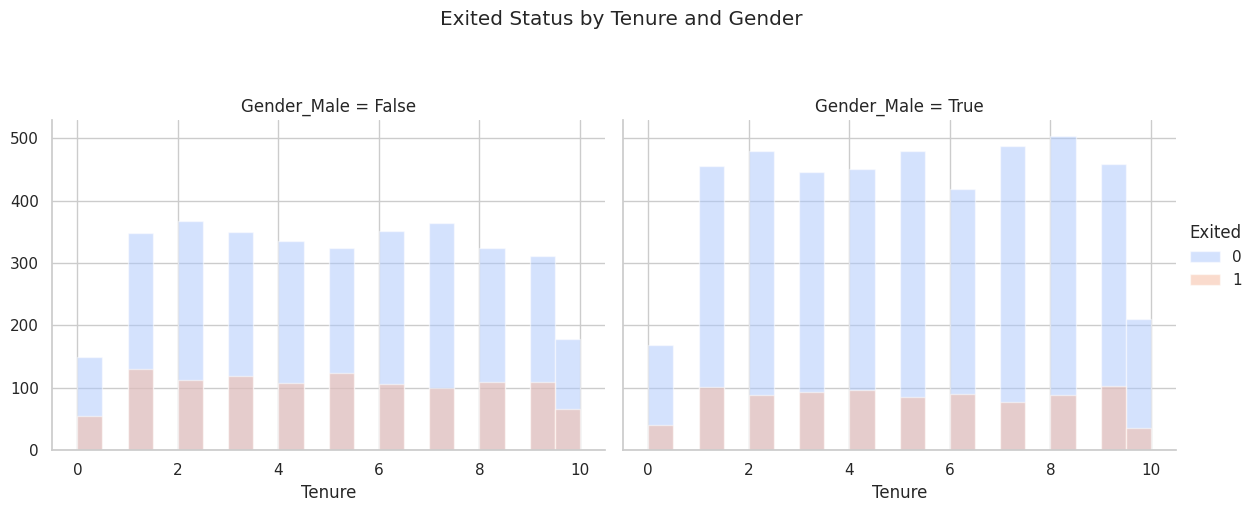

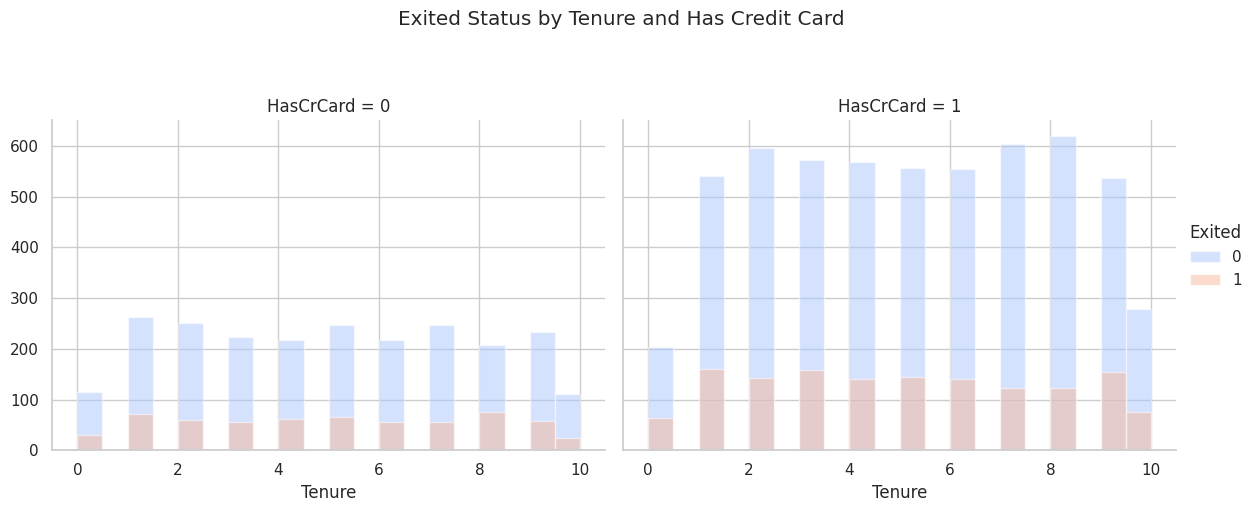

In [ ]:

# Repeat for IsActiveMember
g = sns.FacetGrid(data, col='IsActiveMember', hue='Exited', palette='coolwarm', height=5, aspect=1.2)
g.map(plt.hist, 'Tenure', alpha=0.5, bins=20)
g.add_legend()
plt.subplots_adjust(top=0.8)
plt.suptitle('Exited Status by Tenure and IsActiveMember', y=1.02)
plt.show()


# Repeat for Gender
g = sns.FacetGrid(data, col='Gender_Male', hue='Exited', palette='coolwarm', height=5, aspect=1.2)
g.map(plt.hist, 'Tenure', alpha=0.5, bins=20)
g.add_legend()
plt.subplots_adjust(top=0.8)
plt.suptitle('Exited Status by Tenure and Gender', y=1.02)
plt.show()

# Repeat for HasCrCard
g = sns.FacetGrid(data, col='HasCrCard', hue='Exited', palette='coolwarm', height=5, aspect=1.2)
g.map(plt.hist, 'Tenure', alpha=0.5, bins=20)
g.add_legend()
plt.subplots_adjust(top=0.8)
plt.suptitle('Exited Status by Tenure and Has Credit Card', y=1.02)
plt.show()

#### NOTES:
- Credit Score, Has Credit Card, Tenure, Estimated Salary (original or centered or netted)
seem to have NO relation to Exited - nether alone nor interlocked with other var
- Potentially best predictors are:
  - Age (original or netted)
  - Gender
  - Is Active Member
  - Number of Products
  - Balance (original or centered or netted)

  #### SUGGESTIONS:
  - drop Credit Score, Has Credit Card, Tenure, Estimated Salary (original and centered and netted) from analysis


## Data Preprocessing

In [ ]:
     # Lets Delete Credit Score, Has Credit Card, Tenure, Estimated Salary based on previous step findigs and reco
data_cln=data.copy()

data_cln = data_cln.drop(columns=['CreditScore', 'Tenure', 'HasCrCard', 'EstimatedSalary', 'EstimatedSalary_cnt', 'EstimatedSalary_cnt_net'])
data_cln.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                10000 non-null  int64  
 1   Balance            10000 non-null  float64
 2   NumOfProducts      10000 non-null  int64  
 3   IsActiveMember     10000 non-null  int64  
 4   Exited             10000 non-null  int64  
 5   Set                10000 non-null  object 
 6   Balance_cnt        10000 non-null  float64
 7   Age_net            10000 non-null  int64  
 8   Balance_cnt_net    10000 non-null  int64  
 9   Gender_Male        10000 non-null  bool   
 10  Geography_Germany  10000 non-null  bool   
 11  Geography_Spain    10000 non-null  bool   
dtypes: bool(3), float64(2), int64(6), object(1)
memory usage: 732.5+ KB


### Let's check reamaining variable with high values for outliers

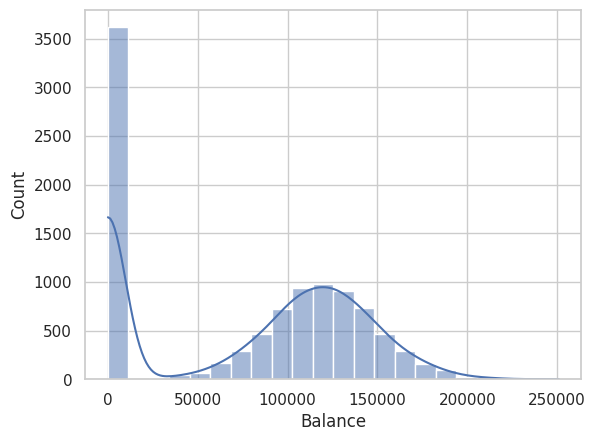

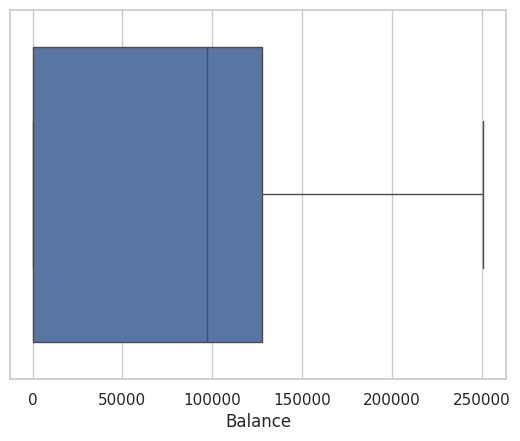

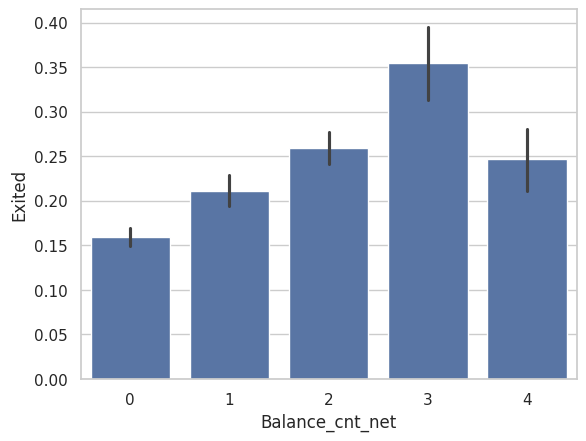

In [ ]:
sns.histplot(data=data_cln, x='Balance', kde=True)
plt.show()

sns.boxplot(data=data_cln, x='Balance')
plt.show()

sns.barplot(data=data_cln, x='Balance_cnt_net', y='Exited')
plt.show()

### NOTES:
- Balance does not show oulier issue

In [ ]:
data_cln.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                10000 non-null  int64  
 1   Balance            10000 non-null  float64
 2   NumOfProducts      10000 non-null  int64  
 3   IsActiveMember     10000 non-null  int64  
 4   Exited             10000 non-null  int64  
 5   Set                10000 non-null  object 
 6   Balance_cnt        10000 non-null  float64
 7   Age_net            10000 non-null  int64  
 8   Balance_cnt_net    10000 non-null  int64  
 9   Gender_Male        10000 non-null  bool   
 10  Geography_Germany  10000 non-null  bool   
 11  Geography_Spain    10000 non-null  bool   
dtypes: bool(3), float64(2), int64(6), object(1)
memory usage: 732.5+ KB


In [ ]:
data_cln.nunique()

Age                    70
Balance              6382
NumOfProducts           4
IsActiveMember          2
Exited                  2
Set                     3
Balance_cnt          6388
Age_net                 7
Balance_cnt_net         5
Gender_Male             2
Geography_Germany       2
Geography_Spain         2
dtype: int64

### RESCALE or NORMALIZE DATA

In [ ]:
# Rescaling numericals to 0-1: Age, Age_net, Balance, Balance_cnt, Balance_cnt_net, NumOfProducts


      # Define columns to scale
columns_to_scale = ['Age', 'Age_net', 'Balance', 'Balance_cnt', 'Balance_cnt_net', 'NumOfProducts']

      # Create scalers for each subset of data
scalers = {
    'Train': MinMaxScaler(),
    'Validation': MinMaxScaler(),
    'Test': MinMaxScaler()
}

      # Scale the numerical columns separately for train, validation, and test sets
for set_name in scalers:
      # Filter rows belonging to the current set
    subset = data_cln[data_cln['Set'] == set_name]

      # Fit and transform the data using MinMaxScaler
    scaled_values = scalers[set_name].fit_transform(subset[columns_to_scale])

      # Update the original dataset with the scaled values
    data_cln.loc[data_cln['Set'] == set_name, columns_to_scale] = scaled_values

      # Display the first few rows of the dataset to verify scaling
data_cln.head(20)


Age   Balance  NumOfProducts  IsActiveMember  Exited         Set  \
0   0.365079  0.635453       0.000000               0       0        Test   
1   0.270270  0.000000       0.333333               1       0       Train   
2   0.432432  0.000000       0.333333               1       0       Train   
3   0.297297  0.000000       0.000000               0       0       Train   
4   0.310811  0.449665       0.333333               0       0       Train   
5   0.285714  0.000000       0.333333               0       0        Test   
6   0.405405  0.000000       0.333333               0       0       Train   
7   0.337838  0.429916       0.000000               1       1       Train   
8   0.216216  0.590653       0.000000               0       0       Train   
9   0.206349  0.600262       0.000000               0       0        Test   
10  0.285714  0.000000       0.333333               0       0        Test   
11  0.243243  0.000000       0.333333               0       0       Train   
12  0.333333  0.000000       0.333333               1       0  Validation   
13  0.391892  0.427955       0.000000               0       0       Train   
14  0.303030  0.000000       0.333333               0       0  Validation   
15  0.121212  0.584176       0.000000               1       0  Validation   
16  0.257576  0.295998       0.000000               0       0  Validation   
17  0.227273  0.000000       0.000000               1       0  Validation   
18  0.303030  0.000000       0.000000               1       0  Validation   
19  0.287879  0.462920       0.333333               0       0  Validation   

    Balance_cnt   Age_net  Balance_cnt_net  Gender_Male  Geography_Germany  \
0      0.456298  0.666667             1.00         True               True   
1      0.118882  0.500000             0.00        False              False   
2      0.118273  1.000000             0.00         True              False   
3      0.118273  0.666667             0.00         True              False   
4      0.515090  0.666667             0.25        False              False   
5      0.099329  0.500000             0.00         True              False   
6      0.118882  0.833333             0.00         True              False   
7      0.270629  0.666667             0.00         True               True   
8      0.638708  0.333333             0.50        False              False   
9      0.424633  0.166667             1.00         True               True   
10     0.099329  0.500000             0.00        False              False   
11     0.118273  0.500000             0.00         True              False   
12     0.124564  0.666667             0.00         True              False   
13     0.495352  0.833333             0.00         True              False   
14     0.124564  0.500000             0.00        False              False   
15     0.394845  0.000000             0.50         True               True   
16     0.386485  0.333333             0.00         True              False   
17     0.127358  0.166667             0.00         True              False   
18     0.124564  0.500000             0.00        False              False   
19     0.288693  0.500000             0.00         True               True   

    Geography_Spain  
0             False  
1              True  
2             False  
3             False  
4              True  
5             False  
6              True  
7             False  
8             False  
9             False  
10            False  
11            False  
12            False  
13            False  
14            False  
15            False  
16             True  
17             True  
18            False  
19            False

### Train-validation-test Split

In [ ]:
# Now with all varsiables been treated and transofrmet seprately within TRAIN / VALIDATE / TEST portion of data, we can finally split them

      # X Features: All columns except 'Exited' and 'Set'
X = data_cln.drop(['Exited', 'Set'], axis=1)

      # Target: 'Exited' column
y = data_cln['Exited']

# Training Set
X_train = X[data_cln['Set'] == 'Train']
y_train = y[data_cln['Set'] == 'Train']

# Validation Set
X_val = X[data_cln['Set'] == 'Validation']
y_val = y[data_cln['Set'] == 'Validation']

# Test Set
X_test = X[data_cln['Set'] == 'Test']
y_test = y[data_cln['Set'] == 'Test']

In [ ]:
print(X_train.shape[0], "train records with ", X_train.shape[1], " predictors")
print(X_val.shape[0], "validation records with ", X_train.shape[1], " predictors")
print(X_test.shape[0], "test records with ", X_train.shape[1], " predictors")

6000 train records with  10  predictors
2000 validation records with  10  predictors
2000 test records with  10  predictors


## Model Building

### Model Evaluation Criterion

Logic for choosing the metric that would be the best metric for this business scenario:
##### If the cost of losing a customer is high, and we want to capture as many at-risk customers as possible, Recall is the most important metric.
By default lifetime value of business lost from a customer (false negative detection) is greater than any loss assoicated with overspend on single retention effort for a customer who would not exit even without such efforts (false positive detection)

In [ ]:
# Function to plot Loss , REcall history: an object which stores the metrics and losses. The name: can be one of Loss or Recall
def plot(history, name):
    fig, ax = plt.subplots() #Creating a subplot with figure and axes.
    plt.plot(history.history[name.lower()]) #Plotting the train Recall or train loss
    plt.plot(history.history['val_'+name.lower()]) #Plotting the validation Recall or validation loss

    plt.title('Model ' + name.capitalize()) #Defining the title of the plot.
    plt.ylabel(name.capitalize()) #Capitalizing the first letter.
    plt.xlabel('Epoch') #Defining the label for the x-axis.
    fig.legend(['Train', 'Validation'], loc="outside right upper") #Defining the legend, loc controls the position of the legend.

In [ ]:
#Savinghyper parameters and the metrics.
cols = ["# hidden layers","# neurons - hidden layer","activation function - hidden layer ","# epochs","batch size","optimizer","learning rate, momentum","weight initializer","regularization","train loss","validation loss","train recall","validation recall","time (secs)"]
results = pd.DataFrame(columns=cols)

## Model_0: Neural Network with SGD Optimizer

In [ ]:
      # Initialization
tf.keras.backend.clear_session()
keras.utils.set_random_seed(416)
batch_size = 32
epochs = 50
num_classes = 1


    #Initializing the neural network
model_0 = Sequential()
model_0.add(Dense(64,activation="relu",input_dim = X_train.shape[1]))
model_0.add(Dense(32,activation="relu"))
model_0.add(Dense(num_classes,activation = 'tanh'))

model_0.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,817 (11.00 KB)

 Trainable params: 2,817 (11.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
    # Selecting SGD and Recall for optimization
optimizer = tf.keras.optimizers.SGD(0.001)
metric = keras.metrics.Recall()

    # Compiling the model
model_0.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[metric])


In [ ]:
start = time.time()
history = model_0.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs)
end=time.time()

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3459 - recall: 0.0000e+00 - val_loss: 0.4836 - val_recall: 0.0000e+00
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4667 - recall: 0.0000e+00 - val_loss: 0.4650 - val_recall: 0.0000e+00
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4518 - recall: 0.0000e+00 - val_loss: 0.4598 - val_recall: 0.0000e+00
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4407 - recall: 0.0000e+00 - val_loss: 0.4608 - val_recall: 0.0000e+00
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4426 - recall: 0.0000e+00 - val_loss: 0.4475 - val_recall: 0.0000e+00
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7369 - recall: 0.4805 - val_loss: 0.6292 - val_recall: 0.2604
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5758 - recall: 0.1009 - val_loss: 0.5003 - val_recall: 0.0000e+00
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4875 - recall: 0.0000e+00 

In [ ]:
print("Time taken in seconds ",end-start)

Time taken in seconds  37.117488384246826


In [ ]:
print(history.history.keys()) # check keys names in history

dict_keys(['loss', 'recall', 'val_loss', 'val_recall'])


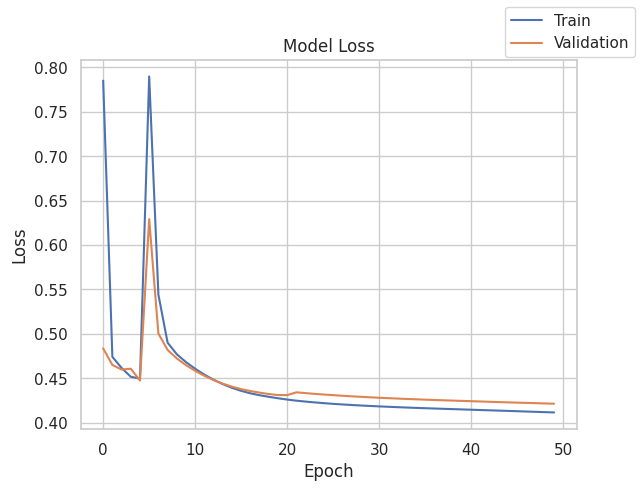

In [ ]:
plot(history,'loss')

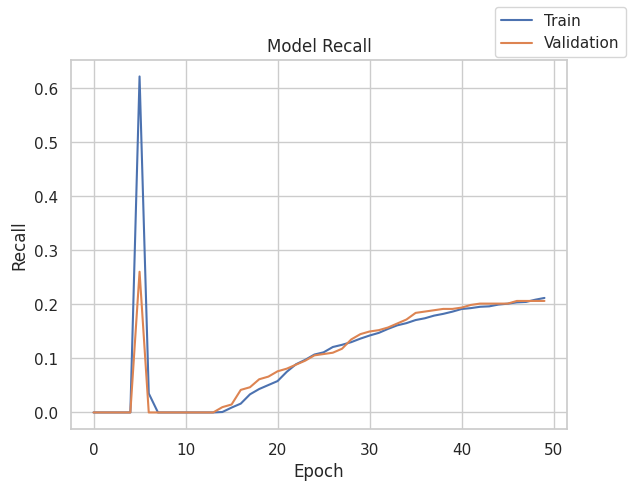

In [ ]:
plot(history,'recall')

### NOTES:
- Model probably experienced temporary gradient explosion at epoch #6 due to learning rate to high

## Model Performance Improvement

## Model_1: Neural Network with Adam Optimizer

In [ ]:
      # Initialization
tf.keras.backend.clear_session()
keras.utils.set_random_seed(416)
batch_size = 32
epochs = 50
num_classes = 1


    #Initializing the neural network
model_1 = Sequential()
model_1.add(Dense(64,activation="relu",input_dim = X_train.shape[1]))
model_1.add(Dense(32,activation="relu"))
model_1.add(Dense(num_classes,activation = 'tanh'))

model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,817 (11.00 KB)

 Trainable params: 2,817 (11.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
    # Selecting Adam and Recall for optimization
optimizer = tf.keras.optimizers.Adam(0.001)
# metric = keras.metrics.Recall()

    # Compiling the model
model_1.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[metric])

start = time.time()
history = model_1.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs)
end=time.time()

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.6044 - recall: 0.1025 - val_loss: 0.4738 - val_recall: 0.0885
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4509 - recall: 0.0789 - val_loss: 0.4408 - val_recall: 0.1597
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4250 - recall: 0.1434 - val_loss: 0.4158 - val_recall: 0.1990
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4092 - recall: 0.2042 - val_loss: 0.5458 - val_recall: 0.5356
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4736 - recall: 0.2820 - val_loss: 0.4105 - val_recall: 0.2457
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3981 - recall: 0.2725 - val_loss: 0.4063 - val_recall: 0.2924
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3840 - recall: 0.2963 - val_loss: 0.4056 - val_recall: 0.3120
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3750 - recall: 0.3197 - val_loss: 0.4008 - val_recall: 0.3268
Epoch 9/

In [ ]:
print(history.history.keys()) # check keys names in history

dict_keys(['loss', 'recall', 'val_loss', 'val_recall'])


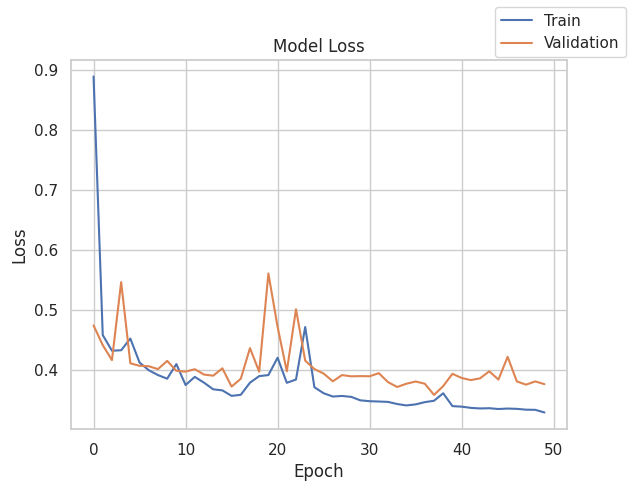

In [ ]:
plot(history,'loss')

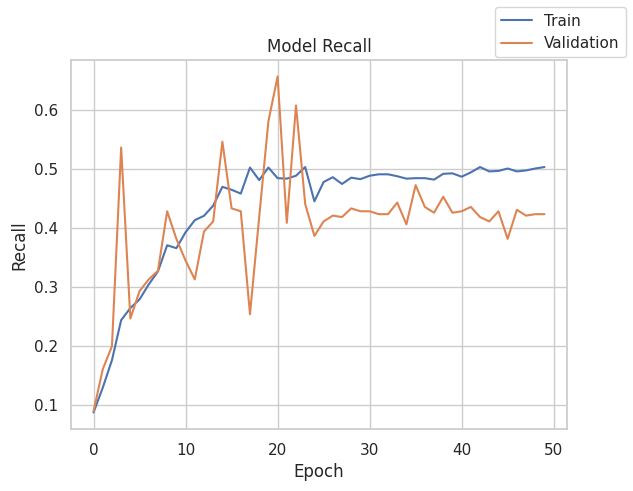

In [ ]:
plot(history,'recall')

### Model_2: Neural Network with Adam Optimizer and Dropout

In [ ]:
      # Initialization
tf.keras.backend.clear_session()
keras.utils.set_random_seed(416)
batch_size = 32
epochs = 50
num_classes = 1


    #Initializing the neural network
model_2 = Sequential()
model_2.add(Dense(64,activation="relu",input_dim = X_train.shape[1]))
model_2.add(Dropout(0.2))
model_2.add(Dense(32,activation="relu"))
model_2.add(Dropout(0.1))
model_2.add(Dense(32,activation="relu"))
model_2.add(Dense(num_classes,activation = 'tanh'))



model_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,873 (15.13 KB)

 Trainable params: 3,873 (15.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
   # Selecting Adam and Recall for optimization
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
# metric = keras.metrics.Recall()

    # Compiling the model
model_2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[metric])

start = time.time()
history = model_2.fit(X_train, y_train, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs)
end=time.time()

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5299 - recall: 0.3457 - val_loss: 0.4635 - val_recall: 0.0025
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4685 - recall: 0.0404 - val_loss: 0.4428 - val_recall: 0.0147
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4480 - recall: 0.0914 - val_loss: 0.4319 - val_recall: 0.0614
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4346 - recall: 0.1030 - val_loss: 0.4260 - val_recall: 0.0786
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4332 - recall: 0.1314 - val_loss: 0.4233 - val_recall: 0.0885
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4312 - recall: 0.1558 - val_loss: 0.4224 - val_recall: 0.1081
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4252 - recall: 0.1493 - val_loss: 0.4197 - val_recall: 0.1179
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4239 - recall: 0.1658 - val_loss: 0.4183 - val_recall: 0.1450
Epoch 9/

In [ ]:
print(history.history.keys()) # check keys names in history

dict_keys(['loss', 'recall', 'val_loss', 'val_recall'])


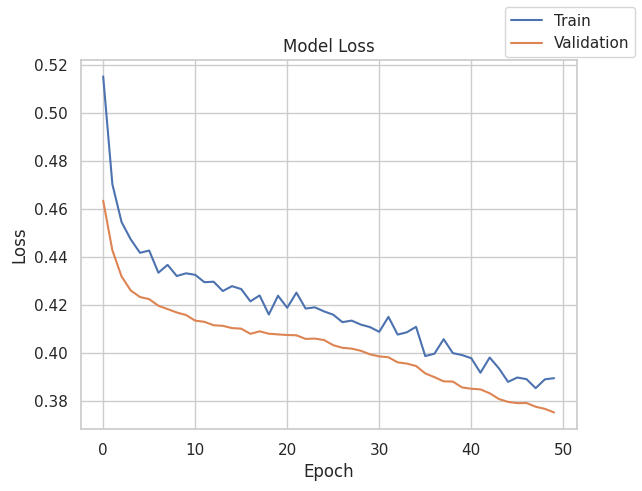

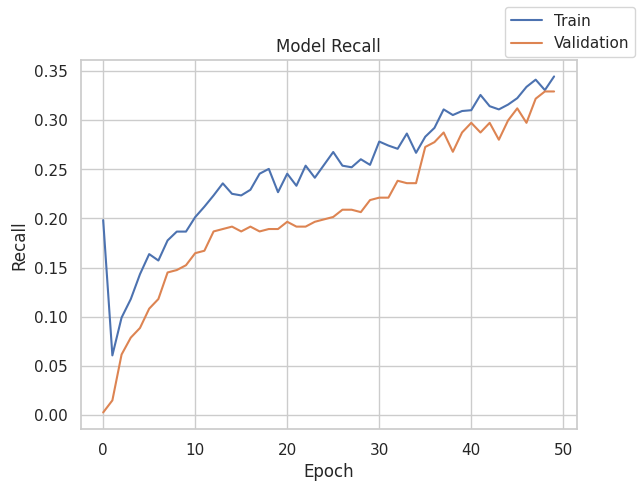

In [ ]:
plot(history,'loss')
plot(history,'recall')

### Model_3: Neural Network with Balanced Data (by applying SMOTE) and SGD Optimizer

In [ ]:
# DataTransformation SMOTE
smt  = SMOTE(random_state=416)
X_train_smt, y_train_smt= smt.fit_resample(X_train, y_train)
print('UpSampled X_train: {}'.format(X_train_smt.shape))
print('UpSampled y_train: {} \n'.format(y_train_smt.shape))

UpSampled X_train: (9556, 10)
UpSampled y_train: (9556,) 



In [ ]:
print('Original y_train: {} \n'.format(y_train.value_counts()))
print('UpSampled y_train: {} \n'.format(y_train_smt.value_counts()))


Original y_train: Exited
0    4778
1    1222
Name: count, dtype: int64 

UpSampled y_train: Exited
0    4778
1    4778
Name: count, dtype: int64 



In [ ]:
      # Initialization
tf.keras.backend.clear_session()
keras.utils.set_random_seed(416)
batch_size = 32
epochs = 50
num_classes = 1


    #Initializing the neural network
model_3 = Sequential()
model_3.add(Dense(64,activation="relu",input_dim = X_train_smt.shape[1]))
model_3.add(Dense(32,activation="relu"))
model_3.add(Dense(32,activation="relu"))
model_3.add(Dense(num_classes,activation = 'tanh'))

model_3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,873 (15.13 KB)

 Trainable params: 3,873 (15.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
    # Selecting SGD and Recall for optimization
optimizer = tf.keras.optimizers.SGD(0.001)

    # Compiling the model
model_3.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[metric])


start = time.time()
history = model_3.fit(X_train_smt, y_train_smt, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs)
end=time.time()

Epoch 1/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2601 - recall: 0.1832 - val_loss: 0.6759 - val_recall: 0.6585
Epoch 2/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6671 - recall: 0.6129 - val_loss: 0.6475 - val_recall: 0.6929
Epoch 3/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6423 - recall: 0.6540 - val_loss: 0.6239 - val_recall: 0.7052
Epoch 4/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6227 - recall: 0.6613 - val_loss: 0.6041 - val_recall: 0.7101
Epoch 5/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6056 - recall: 0.6606 - val_loss: 0.5886 - val_recall: 0.7125
Epoch 6/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5918 - recall: 0.6869 - val_loss: 0.5773 - val_recall: 0.7101
Epoch 7/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5814 - recall: 0.6995 - val_loss: 0.5715 - val_recall: 0.7297
Epoch 8/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5742 - recall: 0.7109 - val_loss: 0.5690 - val_recall: 0.7322
Epoch 9/

dict_keys(['loss', 'recall', 'val_loss', 'val_recall'])


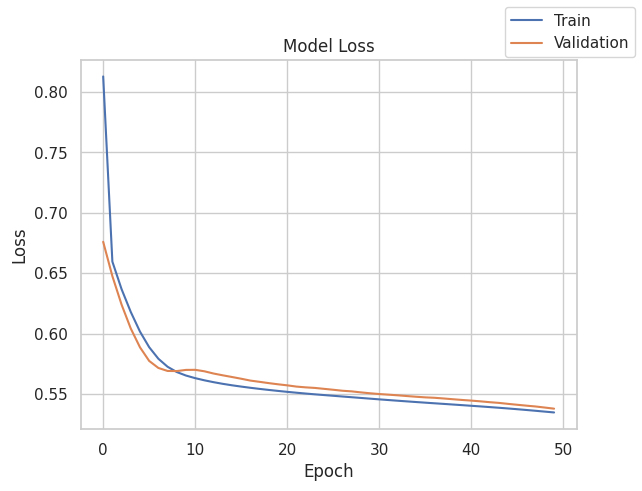

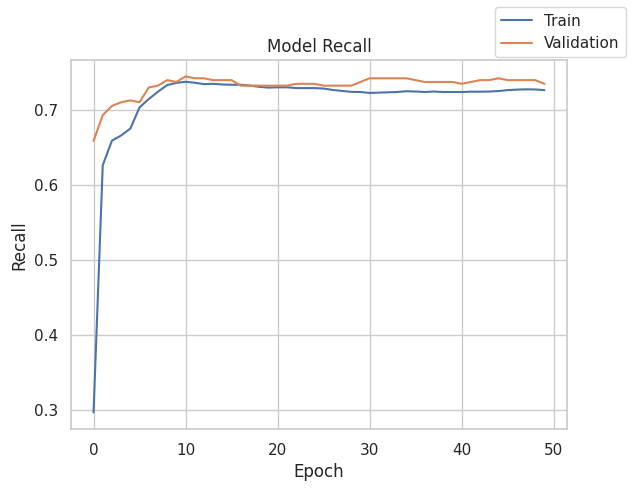

In [ ]:
print(history.history.keys()) # check keys names in history
plot(history,'loss')
plot(history,'recall')

### Model_4: Neural Network with Balanced Data (by applying SMOTE) and Adam Optimizer

In [ ]:
      # Initialization
tf.keras.backend.clear_session()
keras.utils.set_random_seed(416)
batch_size = 32
epochs = 50
num_classes = 1


    #Initializing the neural network
model_4 = Sequential()
model_4.add(Dense(64,activation="relu",input_dim = X_train_smt.shape[1]))
model_4.add(Dense(16,activation="relu"))
model_4.add(Dense(32,activation="relu"))
model_4.add(Dense(num_classes,activation = 'tanh'))

model_4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,321 (9.07 KB)

 Trainable params: 2,321 (9.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
   # Selecting Adam and Recall for optimization
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
# metric = keras.metrics.Recall()

    # Compiling the model
model_4.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[metric])

start = time.time()
history = model_4.fit(X_train_smt, y_train_smt, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs)
end=time.time()

Epoch 1/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.8636 - recall: 0.1531 - val_loss: 0.4788 - val_recall: 0.0123
Epoch 2/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7376 - recall: 0.0693 - val_loss: 0.5360 - val_recall: 0.4177
Epoch 3/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6249 - recall: 0.5238 - val_loss: 0.5835 - val_recall: 0.6658
Epoch 4/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5944 - recall: 0.6810 - val_loss: 0.5822 - val_recall: 0.7150
Epoch 5/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5778 - recall: 0.7080 - val_loss: 0.5720 - val_recall: 0.7273
Epoch 6/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5657 - recall: 0.7181 - val_loss: 0.5629 - val_recall: 0.7248
Epoch 7/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5575 - recall: 0.7148 - val_loss: 0.5653 - val_recall: 0.7248
Epoch 8/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5522 - recall: 0.7209 - val_loss: 0.5651 - val_recall: 0.7322
Epoch 9/

Time taken in seconds  62.32919692993164
dict_keys(['loss', 'recall', 'val_loss', 'val_recall'])


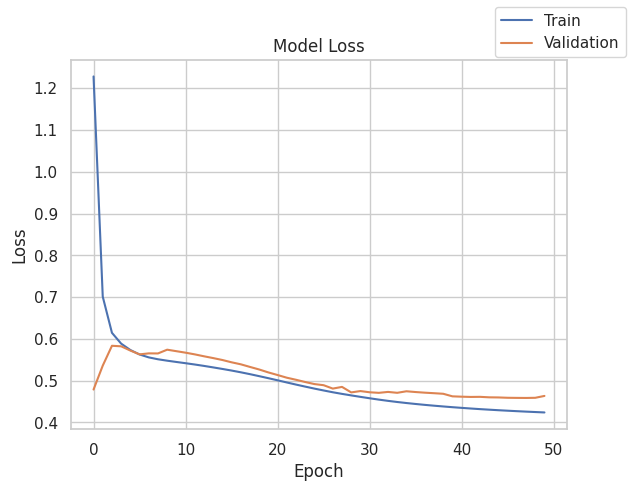

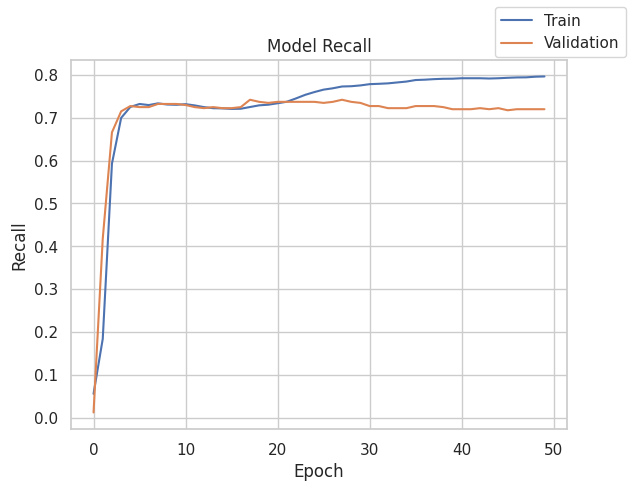

In [ ]:
print("Time taken in seconds ",end-start)
print(history.history.keys()) # check keys names in history
plot(history,'loss')
plot(history,'recall')

### Model_5: Neural Network with Balanced Data (by applying SMOTE), Adam Optimizer, and Dropout

In [ ]:
      # Initialization
tf.keras.backend.clear_session()
keras.utils.set_random_seed(416)
batch_size = 32
epochs = 50
num_classes = 1


    #Initializing the neural network
model_5 = Sequential()
model_5.add(Dense(64,activation="relu",input_dim = X_train_smt.shape[1]))
model_5.add(Dropout(0.2))
model_5.add(Dense(16,activation="relu"))
model_5.add(Dropout(0.1))
model_5.add(Dense(32,activation="relu"))
model_5.add(Dense(num_classes,activation = 'tanh'))

model_5.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,321 (9.07 KB)

 Trainable params: 2,321 (9.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
   # Selecting Adam and Recall for optimization
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
# metric = keras.metrics.Recall()

    # Compiling the model
model_5.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[metric])

start = time.time()
history = model_5.fit(X_train_smt, y_train_smt, validation_data=(X_val,y_val) , batch_size=batch_size, epochs=epochs)
end=time.time()

Epoch 1/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.6646 - recall: 0.5179 - val_loss: 0.5889 - val_recall: 0.7027
Epoch 2/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6016 - recall: 0.6813 - val_loss: 0.5677 - val_recall: 0.7273
Epoch 3/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5844 - recall: 0.7094 - val_loss: 0.5557 - val_recall: 0.7199
Epoch 4/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5782 - recall: 0.6885 - val_loss: 0.5500 - val_recall: 0.7199
Epoch 5/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5727 - recall: 0.7010 - val_loss: 0.5445 - val_recall: 0.7174
Epoch 6/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5611 - recall: 0.7094 - val_loss: 0.5409 - val_recall: 0.7125
Epoch 7/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5632 - recall: 0.6938 - val_loss: 0.5357 - val_recall: 0.7052
Epoch 8/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5629 - recall: 0.7026 - val_loss: 0.5303 - val_recall: 0.7052
Epoch 9/

Time taken in seconds  65.7030975818634
dict_keys(['loss', 'recall', 'val_loss', 'val_recall'])


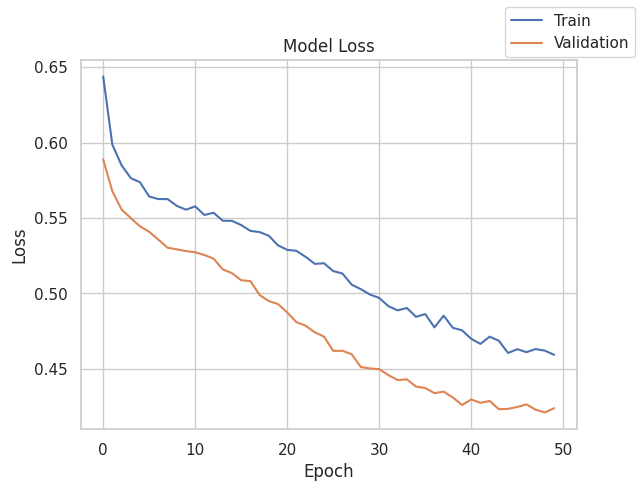

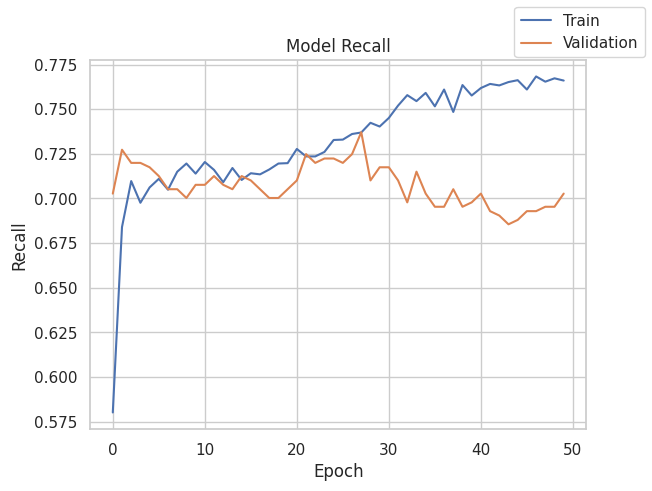

In [ ]:
print("Time taken in seconds ",end-start)
print(history.history.keys()) # check keys names in history
plot(history,'loss')
plot(history,'recall')

### **Model Performance Comparison and Final Model Selection**

Models developed performed as follows:
- Model 0:  Train / Validation Recall = 0.2062 / 0.2064  
- Model 1:  Train / Validation Recall = 0.5138 / 0.4226
- Model 2:  Train / Validation Recall = 0.3514 / 0.3292
- Model 3:  Train / Validation Recall = 0.7166 / 0.7346
- Model 4:  Train / Validation Recall = 0.7863 / 0.7199
- Model 5:  Train / Validation Recall = 0.7499 / 0.7027




The highest recall models tested on Validation Set are Model #3 and Model #4.
But model # 3 ("Model_3: Neural Network with Balanced Data (by applying SMOTE) and SGD Optimizer") is the highest at 73% recall but also has low gap to Train recall suggesting unlikely room for being overfit.

### **Final Model Evaluation on Test portion of Data**



In [ ]:
# Evaluate the model on the test data
test_loss, test_recall = model_3.evaluate(X_test, y_test, batch_size=batch_size)

# Print the evaluation results
print(f"Test Loss: {test_loss}")
print(f"Test Recall: {test_recall}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5345 - recall: 0.7588
Test Loss: 0.5447555184364319
Test Recall: 0.7377451062202454


TheFinal Model #3
("Neural Network with Balanced Data (by applying SMOTE) and SGD Optimizer") deliver comparable and Acceptable Recall on Test Set = 73.8% vs 73.5% on Validation set.

This indicates good generalization, absence of overfitting.



## Actionable Insights and Business Recommendations

**Actionable Insights:**
Identified Key Predictors of Churn:

- The features that strongly influenced customer churn were Age, Number of Products, Balance, Gender, and Active Membership.
- Balance and Active Membership have significant relationships with churn, whereas variables like Credit Score and Estimated Salary showed little to no impact.

**Geographic Influence**:

There were significant differences in customer behavior across Geography. For example, balance distribution varied across regions, suggesting that location-specific interventions might be effective for churn reduction.

**Impact of Customer Engagement**:

Customers who are active members were less likely to churn, indicating that consistent engagement is key to retention.


**Ineffective Features**:

Variables such as Credit Score, Has Credit Card, and Tenure showed limited impact on predicting churn. These features were subsequently dropped from the model for more efficient predictions.


**Business Recommendations:**
Focus on Customer Engagement:

- Increase efforts to keep customers active by incentivizing engagement with bank products and services. Target campaigns to inactive customers to encourage usage, possibly through personalized rewards or loyalty programs.

**Tailored Retention Strategies by Geography:**

Since churn drivers vary by region, develop targeted interventions based on geographic-specific needs. For example, different product offerings or promotional campaigns could be more effective in certain regions.

**Product Cross-Selling**:

- Promote cross-selling opportunities to customers with fewer products. The analysis showed that the Number of Products held by a customer is negatively correlated with churn. Encouraging customers to adopt more products can improve loyalty.


**Retention Programs for Specific Age Groups**:

Younger customers and those with lower balances are more likely to churn. Design specific retention programs targeting these demographics to increase satisfaction and retention, such as financial education for younger customers or special savings plans.

**Note**:
Features like Credit Score, Has Credit Card, and Estimated Salary were found to be ineffective in predicting churn. Future analyses should exclude these features to simplify the model and focus resources on impactful variables.

*




___